
Branin: 2D


In [ ]:
pip install pyGPGO


  Created wheel for pyGPGO: filename=pyGPGO-0.5.1-py3-none-any.whl size=19879 sha256=8cdbe9a1eb5dfc8231c55d06938da607df8eacae897d5ae52ceb6fac2dcd1cc2
  Stored in directory: /root/.cache/pip/wheels/c8/5d/0b/2160114e2f1b87791c51b66cf07f89831dbb6f49167950316f
Successfully built pyGPGO


In [ ]:
### Import:

import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import warnings
import itertools

from pyGPGO.GPGO import GPGO
from pyGPGO.surrogates.GaussianProcess import GaussianProcess
from pyGPGO.acquisition import Acquisition
from pyGPGO.covfunc import squaredExponential

from joblib import Parallel, delayed
from numpy.linalg import solve, cholesky
from scipy.spatial.distance import cdist
from scipy.optimize import minimize
from scipy.stats import norm
import time

warnings.filterwarnings("ignore", category=RuntimeWarning)


In [ ]:
### Inputs:

func = 'Branin'
n_test = 500
eps = 1e-08

util_grad_exact = 'dEI_GP'
util_grad_approx = 'ExpectedImprovement'

n_init = 5 # random initialisations
iters = 20
opt = True

In [ ]:
### Objective Function - Branin(x) 2-D:

def objfunc(x1_training, x2_training, a = 1, b = (5.1 / (4 * (np.pi) ** 2)), c = (5 / (np.pi)), r = 6, s = 10, t = (1 / (8 * np.pi))):
        return operator * ((a * (x2_training - b * x1_training ** 2 + c * x1_training - r) ** 2) + 
                 s * (1 - t) * np.cos(x1_training) + s)
        
# Constraints:
lb_x1 = -5 
ub_x1 = +10
lb_x2 = +0 
ub_x2 = +15

# Input array dimension(s):
dim = 2

# 2-D inputs' parameter bounds:
param = {'x1_training': ('cont', [lb_x1, ub_x1]),
             'x2_training': ('cont', [lb_x2, ub_x2])}

# True y bounds:
operator = -1
y_lb = 0.397887 # targets global minimum
y_global_orig = y_lb * operator # targets global minimum


# Test data:
x1_test = np.linspace(lb_x1, ub_x1, n_test)
x2_test = np.linspace(lb_x2, ub_x2, n_test)
  
x_test = np.column_stack((x1_test,x2_test))


In [ ]:
n_start_AcqFunc = iters


In [ ]:
### Cumulative Regret Calculator:

def min_max_array(x):
    new_list = []
    for i, num in enumerate(x):
            new_list.append(np.min(x[0:i+1]))
    return new_list
  

In [ ]:
### Surrogate derivatives: 

cov_func = squaredExponential()

def kronDelta(X, Xstar):                     # Kronecker's Delta method
    return cdist(X, Xstar) < np.finfo(np.float32).eps

def se(X, Xstar, sigmaf, l, sigman):         # S.E. kernel method
    return sigmaf * np.exp(-0.5 * cdist(X, Xstar) ** 2 / l ** 2) + sigman * kronDelta(X, Xstar)

def delta(X, Xstar):                         # Distance between training X and test Xstar vectors
    return (X - Xstar)
   
def der_covmat(X, Xstar, sigmaf, l, sigman): # Covariance matrix derivative terms (i.e. exact, first-order)
    nx = len(X)
    ny = len(Xstar)
    return np.round(np.array([(delta(np.atleast_2d(i), np.atleast_2d(j))[0] * se(np.atleast_2d(i), np.atleast_2d(j), sigmaf, l, sigman)[0]).sum() for (i, j) in itertools.product(X, Xstar)]).reshape(nx, ny), 8)

class dGaussianProcess(GaussianProcess):    # Via inheritance, also optimises hyperparameters when opt = TRUE
    
    def AcqGrad(self, Xstar):               # Method returning exact, first-order derivatives of the GP's posterior mean and standard deviation
        Xstar = np.atleast_2d(Xstar)
        Kstar = self.covfunc.K(self.X, Xstar).T
        
        dKstar = der_covmat(self.X, Xstar, self.covfunc.sigmaf, self.covfunc.l, self.covfunc.sigman).T
        alpha_Kstar = np.dot(np.linalg.inv(self.K + (self.covfunc.sigman**2) * np.eye(len(self.X))), Kstar.T)
        
        dm = np.dot(dKstar, self.alpha)
        ds = -2 * np.dot(dKstar, alpha_Kstar)
        
        return dm, ds           
        

In [ ]:
class Acquisition_new(Acquisition):    
    def __init__(self, mode, eps=eps, **params):
        
        self.params = params
        self.eps = eps

        mode_dict = {
            'dEI_GP': self.dEI_GP
        }

        self.f = mode_dict[mode]
    
    def dEI_GP(self, tau, mean, std, ds, dm):
        gamma = (mean - tau - self.eps) / (std + self.eps)
        gamma_h = (mean - tau) / (std + self.eps)
        dsdx = ds / (2 * (std + self.eps))
        dmdx = (dm - gamma * dsdx) / (std + self.eps)
        
        f = (std + self.eps) * (gamma * norm.cdf(gamma) + norm.pdf(gamma))
        df1 = f / (std + self.eps) * dsdx 
        df2 = (std + self.eps) * norm.cdf(gamma) * dmdx
        df = (df1 + df2)[0]
        df_arr = []

        for j in range(0, dim):
          df_arr.append(df)
        return f, np.asarray(df_arr).transpose()
        
    def d_eval(self, tau, mean, std, ds, dm):
    
        return self.f(tau, mean, std, ds, dm, **self.params)
        

In [ ]:
## GPGO_multi: 

class GPGO_multi(GPGO):
    n_start = n_start_AcqFunc

    def __init__(self, surrogate, acquisition, f, parameter_dict, n_jobs=1):
        self.GP = surrogate
        self.A = acquisition
        self.f = f
        self.parameters = parameter_dict
        self.n_jobs = n_jobs

        self.parameter_key = list(parameter_dict.keys())
        self.parameter_value = list(parameter_dict.values())
        self.parameter_type = [p[0] for p in self.parameter_value]
        self.parameter_range = [p[1] for p in self.parameter_value]

        self.history = []
        self.header =   'Evaluation \t Proposed point \t  Current eval. \t  Best eval. \t         Max AcqFunc.'
        self.template = '{:3}\t {}\t {:3}\t {:3}\t {:3}'

    def _optimizeAcq(self, method='L-BFGS-B', n_start=n_start_AcqFunc):
        
        start_points_dict = [self._sampleParam() for i in range(n_start)]
        start_points_arr = np.array([list(s.values())
                                     for s in start_points_dict])
        x_best = np.empty((n_start, len(self.parameter_key)))
        f_best = np.empty((n_start,))
        opt = Parallel(n_jobs=self.n_jobs)(delayed(minimize)(self._acqWrapper,
                                                                 x0=start_point,
                                                                 method=method,
                                                                 bounds=self.parameter_range) for start_point in
                                               start_points_arr)
        x_best = np.array([res.x for res in opt])
        f_best = np.array([np.atleast_1d(res.fun)[0] for res in opt])
        f_best_min = min(f_best)

        self.x_best = x_best
        self.f_best = f_best
        self.f_best_min = f_best_min
        self.best = x_best[np.argmin(f_best)]
        self.start_points_arr = start_points_arr
        
        self.history.append(self.f_best_min)
          
    def _printInit(self):
        print(self.header)
        for init_eval in range(self.init_evals):
            print(self.template.format('init', self.GP.X[init_eval], self.GP.y[init_eval], self.tau, ''))
      
    def _printCurrent(self):
        OKGREEN = '\033[92m'
        ENDC = '\033[0m'
        BOLD = '\033[1m'
        eval = str(len(self.GP.y) - self.init_evals)
        proposed = str(self.best)
        curr_eval = str(self.GP.y[-1])
        curr_best = str(self.tau)
        max_acqfunc = str(self.f_best_min)
        if float(curr_eval) >= float(curr_best):
            eval = BOLD + OKGREEN + eval + ENDC
            proposed = BOLD + OKGREEN + proposed + ENDC
            curr_eval = BOLD + OKGREEN + curr_eval + ENDC
            curr_best = BOLD + OKGREEN + curr_best + ENDC
            max_acqfunc = BOLD + OKGREEN + str(self.f_best_min) + ENDC
        print(self.template.format(eval, proposed, curr_eval, curr_best, max_acqfunc))

    def run(self, max_iter=10, init_evals=3, resume=False):
        
        if not resume:
            self.init_evals = init_evals
            self._firstRun(self.init_evals)
            self._printInit()
        for iteration in range(max_iter):
            self._optimizeAcq()
            self.updateGP()
            self._printCurrent()


In [ ]:
## dGPGO:

grad = 1

class dGPGO(GPGO):
    n_start = n_start_AcqFunc

    def __init__(self, surrogate, acquisition, f, parameter_dict, n_jobs=1):
        self.GP = surrogate
        self.A = acquisition
        self.f = f
        self.parameters = parameter_dict
        self.n_jobs = n_jobs

        self.parameter_key = list(parameter_dict.keys())
        self.parameter_value = list(parameter_dict.values())
        self.parameter_type = [p[0] for p in self.parameter_value]
        self.parameter_range = [p[1] for p in self.parameter_value]

        self.history = []
        self.header =   'Evaluation \t Proposed point \t  Current eval. \t  Best eval. \t         Max AcqFunc.'
        self.template = '{:3}\t {}\t {:3}\t {:3}\t {:3}'

    def d_optimizeAcq(self, method='L-BFGS-B', n_start=n_start_AcqFunc):
        start_points_dict = [self._sampleParam() for i in range(n_start)]
        start_points_arr = np.array([list(s.values())
                                     for s in start_points_dict])
        x_best = np.empty((n_start, len(self.parameter_key)))
        f_best = np.empty((n_start,))
        opt = Parallel(n_jobs=self.n_jobs)(delayed(minimize)(self.acqfunc,
                                                                 x0=start_point,
                                                                 method=method,
                                                                 jac = True,
                                                                 bounds=self.parameter_range) for start_point in
                                               start_points_arr)
        x_best = np.array([res.x for res in opt])
        f_best = np.array([np.atleast_1d(res.fun)[0] for res in opt])
        f_best_min = min(f_best)

        self.x_best = x_best
        self.f_best = f_best
        self.f_best_min = f_best_min
        self.best = x_best[np.argmin(f_best)]
        self.start_points_arr = start_points_arr

        self.history.append(self.f_best_min)

    def _printInit(self):
        print(self.header)
        for init_eval in range(self.init_evals):
            print(self.template.format('init', self.GP.X[init_eval], self.GP.y[init_eval], self.tau, ''))
      
    def _printCurrent(self):
        OKGREEN = '\033[92m'
        ENDC = '\033[0m'
        BOLD = '\033[1m'
        eval = str(len(self.GP.y) - self.init_evals)
        proposed = str(self.best)
        curr_eval = str(self.GP.y[-1])
        curr_best = str(self.tau)
        max_acqfunc = str(self.f_best_min)
        if float(curr_eval) >= float(curr_best):
            eval = BOLD + OKGREEN + eval + ENDC
            proposed = BOLD + OKGREEN + proposed + ENDC
            curr_eval = BOLD + OKGREEN + curr_eval + ENDC
            curr_best = BOLD + OKGREEN + curr_best + ENDC
            max_acqfunc = BOLD + OKGREEN + str(self.f_best_min) + ENDC
        print(self.template.format(eval, proposed, curr_eval, curr_best, max_acqfunc))

    def run(self, max_iter=10, init_evals=3, resume=False):
        
        if not resume:
            self.init_evals = init_evals
            self._firstRun(self.init_evals)
            self._printInit()
        for iteration in range(max_iter):
            self.d_optimizeAcq()
            self.updateGP()
            self._printCurrent()

    def acqfunc(self, xnew, n_start=n_start_AcqFunc):
        new_mean, new_var = self.GP.predict(xnew, return_std=True)
        new_std = np.sqrt(new_var + eps)
        dm, ds = self.GP.AcqGrad(xnew)
        f, df = self.A.d_eval(self.tau, new_mean, new_std, ds=ds, dm=dm)

        return -f, -df * grad


In [ ]:
###Reproducible set-seeds:

run_num_1 = 1
run_num_2 = 2
run_num_3 = 3
run_num_4 = 4
run_num_5 = 5
run_num_6 = 6
run_num_7 = 7
run_num_8 = 8
run_num_9 = 9
run_num_10 = 10
run_num_11 = 11
run_num_12 = 12
run_num_13 = 13
run_num_14 = 14
run_num_15 = 15
run_num_16 = 16
run_num_17 = 17
run_num_18 = 18
run_num_19 = 19
run_num_20 = 20


In [ ]:
start_approx = time.time()
start_approx


1649162343.7337263

In [ ]:
### ESTIMATED GP EI GRADIENTS

np.random.seed(run_num_1)
surrogate_approx_1 = GaussianProcess(cov_func, optimize=opt)

approx_1 = GPGO_multi(surrogate_approx_1, Acquisition(util_grad_approx), objfunc, param)
approx_1.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max AcqFunc.
init	 [ 1.25533007 10.8048674 ]	 -56.52874004692151	 -27.68166689936483	    
init	 [-4.99828438  4.53498859]	 -172.66531086516164	 -27.68166689936483	    
init	 [-2.79866164  1.38507892]	 -102.58290348816024	 -27.68166689936483	    
init	 [-2.20609683  5.18341091]	 -28.868064601155666	 -27.68166689936483	    
init	 [0.95151211 8.08225101]	 -27.68166689936483	 -27.68166689936483	    
1	 [8.41909995 1.27566317]	 -5.089934878453152	 -5.089934878453152	 -27.68166689936483
2  	 [ 8.98893195 10.45227242]	 -70.52424256621515	 -5.089934878453152	 -5.093418837438119
3	 [-3.98449353 13.27557148]	 -4.859191184895716	 -4.859191184895716	 -5.09341739546843
4  	 [2.98309456 0.06142284]	 -5.995851987798232	 -4.859191184895716	 -4.864164384109738
5  	 [ 5.33580237 15.        ]	 -206.4381669221689	 -4.859191184895716	 -4.864163565448148
6  	 [5.84928396 5.67126399]	 -39.512784637934104	 -4.859191184895716	 -4.864152794568

In [ ]:
### ESTIMATED GP EI GRADIENTS

np.random.seed(run_num_2)
surrogate_approx_2 = GaussianProcess(cov_func, optimize=opt)

approx_2 = GPGO_multi(surrogate_approx_2, Acquisition(util_grad_approx), objfunc, param)
approx_2.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max AcqFunc.
init	 [1.53992353 0.38889348]	 -22.31361308916297	 -6.692051508754487	    
init	 [3.24493717 6.52983589]	 -19.233109967858276	 -6.692051508754487	    
init	 [1.30551703 4.95502232]	 -13.177851563387286	 -6.692051508754487	    
init	 [-1.93027049  9.2890645 ]	 -6.692051508754487	 -6.692051508754487	    
init	 [-0.50517989  4.00240913]	 -26.437522758780958	 -6.692051508754487	    
1  	 [ 9.5587047  12.00387527]	 -89.09951357262268	 -6.692051508754487	 -6.692265018253458
2	 [9.59366035 1.69164323]	 -1.3984593420568778	 -1.3984593420568778	 -6.692265018253287
3  	 [ 3.24245232 12.67669673]	 -110.25694222671481	 -1.3984593420568778	 -1.6845910263063124
4  	 [-2.58600765 14.70719421]	 -15.7365426981614	 -1.3984593420568778	 -1.6845900558103417
5  	 [-4.49504143  0.        ]	 -256.4427086609612	 -1.3984593420568778	 -1.6845899133907438
6  	 [8.72620884 6.41279807]	 -22.574476808274685	 -1.3984593420568778	 -1.68

In [ ]:
### ESTIMATED GP EI GRADIENTS

np.random.seed(run_num_3)
surrogate_approx_3 = GaussianProcess(cov_func, optimize=opt)

approx_3 = GPGO_multi(surrogate_approx_3, Acquisition(util_grad_approx), objfunc, param)
approx_3.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max AcqFunc.
init	 [ 3.26196854 10.62221734]	 -71.68783452098575	 -18.07886746449891	    
init	 [-0.63642892  7.66241408]	 -18.07886746449891	 -18.07886746449891	    
init	 [ 8.39420432 13.44439633]	 -141.98653529865882	 -18.07886746449891	    
init	 [-3.11622034  3.10864317]	 -83.31045707266176	 -18.07886746449891	    
init	 [-4.22799195  6.61214765]	 -76.5294170688398	 -18.07886746449891	    
1  	 [6.70472147 4.59545299]	 -30.726791812855225	 -18.07886746449891	 -18.07886746449891
2	 [-5. 15.]	 -17.508299515778166	 -17.508299515778166	 -18.07886746449889
3	 [2.64338273 0.68243899]	 -5.61793909734835	 -5.61793909734835	 -17.508297473556393
4  	 [10.  0.]	 -10.960889035651505	 -5.61793909734835	 -5.619414322844939
5  	 [ 0.17998475 15.        ]	 -105.6075359190613	 -5.61793909734835	 -5.619381712176309
6  	 [10.          8.34452441]	 -30.47548723129985	 -5.61793909734835	 -5.619312555250814
7  	 [-0.6195202  11.332942

In [ ]:
### ESTIMATED GP EI GRADIENTS

np.random.seed(run_num_4)
surrogate_approx_4 = GaussianProcess(cov_func, optimize=opt)

approx_4 = GPGO_multi(surrogate_approx_4, Acquisition(util_grad_approx), objfunc, param)
approx_4.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max AcqFunc.
init	 [9.50544759 8.20848374]	 -32.51676744781521	 -7.247126865776948	    
init	 [ 9.5902654  10.72223991]	 -66.20566674364716	 -7.247126865776948	    
init	 [5.46593237 3.24134243]	 -20.90089401680587	 -7.247126865776948	    
init	 [9.64411682 0.09345383]	 -7.247126865776948	 -7.247126865776948	    
init	 [-1.20526456  6.52187299]	 -15.941376982363263	 -7.247126865776948	    
1  	 [ 1.25164457 13.57001383]	 -100.61648848019335	 -7.247126865776948	 -7.247197919961176
2  	 [-4.27198795  1.64727177]	 -188.41076037632916	 -7.247126865776948	 -7.247197419457956
3  	 [-4.64616955 10.91158353]	 -37.15561787434749	 -7.247126865776948	 -7.247196478927118
4  	 [3.91058192 8.49899792]	 -48.62596349349736	 -7.247126865776948	 -7.247186004005792
5  	 [1.24885867 0.        ]	 -30.7947923644144	 -7.247126865776948	 -7.24718456696917
6  	 [ 6.50701313 15.        ]	 -212.19478521338414	 -7.247126865776948	 -7.24714968648

In [ ]:
### ESTIMATED GP EI GRADIENTS

np.random.seed(run_num_5)
surrogate_approx_5 = GaussianProcess(cov_func, optimize=opt)

approx_5 = GPGO_multi(surrogate_approx_5, Acquisition(util_grad_approx), objfunc, param)
approx_5.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max AcqFunc.
init	 [-1.67010243 13.06098459]	 -25.390690545664548	 -25.311309190989615	    
init	 [-1.89921267 13.77916362]	 -25.311309190989615	 -25.311309190989615	    
init	 [2.32616783 9.17615794]	 -41.60147975414021	 -25.311309190989615	    
init	 [6.48861785 7.77626982]	 -63.81281921768236	 -25.311309190989615	    
init	 [-0.54799248  2.81581843]	 -34.966203644931994	 -25.311309190989615	    
1	 [8.84124421 0.03321319]	 -5.96108856337545	 -5.96108856337545	 -25.311309190989423
2  	 [ 8.39476442 14.47736321]	 -167.21523769473345	 -5.96108856337545	 -5.961907109366957
3  	 [-4.1375067   7.24495487]	 -61.80559119709111	 -5.96108856337545	 -5.961905558672704
4  	 [-5.  0.]	 -308.12909601160663	 -5.96108856337545	 -5.961890653984154
5  	 [3.90218642 0.        ]	 -6.129536698755416	 -5.96108856337545	 -5.961875513211085
6  	 [ 3.02991629 15.        ]	 -160.13370433331355	 -5.96108856337545	 -5.961819911480742
7	 [10. 

In [ ]:
### ESTIMATED GP EI GRADIENTS

np.random.seed(run_num_6)
surrogate_approx_6 = GaussianProcess(cov_func, optimize=opt)

approx_6 = GPGO_multi(surrogate_approx_6, Acquisition(util_grad_approx), objfunc, param)
approx_6.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max AcqFunc.
init	 [8.39290227 4.97969708]	 -15.553860636684597	 -15.31731051317483	    
init	 [7.31843685 0.62544939]	 -15.31731051317483	 -15.31731051317483	    
init	 [-3.3851498   8.92578096]	 -16.222288919361837	 -15.31731051317483	    
init	 [2.94726043 6.28211143]	 -15.406373581304088	 -15.31731051317483	    
init	 [0.03111774 9.33779148]	 -31.07053245856209	 -15.31731051317483	    
1  	 [ 9.64829531 12.55362889]	 -98.32295673962142	 -15.31731051317483	 -15.317310513173595
2  	 [-1.22578785  0.62063252]	 -69.8637190838968	 -15.31731051317483	 -15.317310513035173
3  	 [ 4.11366045 15.        ]	 -183.10484285176852	 -15.31731051317483	 -15.317309962767201
4	 [-2.67102288 14.57040418]	 -12.985837564809705	 -12.985837564809705	 -15.317309291701916
5  	 [-5.          4.21652744]	 -180.96625047114895	 -12.985837564809705	 -12.985760115193642
6  	 [5.44161514 9.98674416]	 -94.22618159524357	 -12.985837564809705	 -12.9

In [ ]:
### ESTIMATED GP EI GRADIENTS

np.random.seed(run_num_7)
surrogate_approx_7 = GaussianProcess(cov_func, optimize=opt)

approx_7 = GPGO_multi(surrogate_approx_7, Acquisition(util_grad_approx), objfunc, param)
approx_7.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max AcqFunc.
init	 [-3.85537566 11.69878188]	 -8.299317850233932	 -5.211335324193094	    
init	 [ 1.57613847 10.85197767]	 -59.50408380701259	 -5.211335324193094	    
init	 [9.66984268 8.07743806]	 -29.714921414987273	 -5.211335324193094	    
init	 [2.51680695 1.080767  ]	 -5.211335324193094	 -5.211335324193094	    
init	 [-0.9734153   7.49823751]	 -15.431057204948033	 -5.211335324193094	    
1  	 [-4.97859679  1.38393519]	 -260.3293952774437	 -5.211335324193094	 -5.214210686386747
2  	 [ 7.42679792 14.12713902]	 -178.37635728719692	 -5.211335324193094	 -5.214210667774886
3  	 [8.08940775 0.35854539]	 -9.249625108410735	 -5.211335324193094	 -5.214210325480218
4  	 [-3.39684884  5.54228873]	 -54.79871094423047	 -5.211335324193094	 -5.214210686386747
5  	 [4.51732395 5.9162821 ]	 -28.11667541280732	 -5.211335324193094	 -5.214202666178672
6  	 [-0.88572207 15.        ]	 -72.16042862566053	 -5.211335324193094	 -5.21373210

In [ ]:
### ESTIMATED GP EI GRADIENTS

np.random.seed(run_num_8)
surrogate_approx_8 = GaussianProcess(cov_func, optimize=opt)

approx_8 = GPGO_multi(surrogate_approx_8, Acquisition(util_grad_approx), objfunc, param)
approx_8.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max AcqFunc.
init	 [ 8.10144104 14.52810994]	 -175.17297136347514	 -15.416245468470875	    
init	 [8.0379181  7.96283537]	 -49.32173799887473	 -15.416245468470875	    
init	 [-1.50907508  0.17098206]	 -83.26753461673219	 -15.416245468470875	    
init	 [1.45703227 6.0352704 ]	 -15.416245468470875	 -15.416245468470875	    
init	 [2.84012007 7.17587694]	 -22.49093277852639	 -15.416245468470875	    
1	 [9.77124156 0.43098073]	 -6.499298445992174	 -6.499298445992174	 -15.416245468468238
2  	 [-4.87537438 11.82874897]	 -36.57081146531108	 -6.499298445992174	 -6.499606284903054
3  	 [ 1.38217397 12.68390036]	 -86.39656029252868	 -6.499298445992174	 -6.499605297388829
4  	 [-5.          4.93391962]	 -162.87055456893222	 -6.499298445992174	 -6.499605167037432
5  	 [4.40861409 1.05852811]	 -7.31765987324756	 -6.499298445992174	 -6.499603688598693
6  	 [-1.71652812  8.75489851]	 -8.733549018250445	 -6.499298445992174	 -6.4969287

In [ ]:
### ESTIMATED GP EI GRADIENTS

np.random.seed(run_num_9)
surrogate_approx_9 = GaussianProcess(cov_func, optimize=opt)

approx_9 = GPGO_multi(surrogate_approx_9, Acquisition(util_grad_approx), objfunc, param)
approx_9.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max AcqFunc.
init	 [-4.84438769  7.52811888]	 -96.15564306553264	 -3.4640248583909496	    
init	 [2.4365994  2.00744293]	 -3.4640248583909496	 -3.4640248583909496	    
init	 [-2.86833372  3.27838013]	 -70.46930174488207	 -3.4640248583909496	    
init	 [1.27762271 3.72151753]	 -12.982825924833865	 -3.4640248583909496	    
init	 [-3.73910523  5.1824796 ]	 -75.58547400560856	 -3.4640248583909496	    
1  	 [ 7.05609655 14.75038872]	 -200.4388688685465	 -3.4640248583909496	 -3.497841812837074
2  	 [-0.46054038 14.56197292]	 -79.4666617606301	 -3.4640248583909496	 -3.497841812786204
3  	 [8.28747407 1.2035024 ]	 -6.196385269800155	 -3.4640248583909496	 -3.497841778185636
4  	 [7.59766367 8.71517487]	 -66.45862359135464	 -3.4640248583909496	 -3.4978407908017397
5  	 [1.7566144  9.14390932]	 -38.92895201137776	 -3.4640248583909496	 -3.4978370358354542
6  	 [-5.         12.67604545]	 -33.075714196778804	 -3.4640248583909496	 -

In [ ]:
### ESTIMATED GP EI GRADIENTS

np.random.seed(run_num_10)
surrogate_approx_10 = GaussianProcess(cov_func, optimize=opt)

approx_10 = GPGO_multi(surrogate_approx_10, Acquisition(util_grad_approx), objfunc, param)
approx_10.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max AcqFunc.
init	 [6.56980965 0.31127924]	 -19.863985024602144	 -2.710610964564512	    
init	 [ 4.50472352 11.23205824]	 -103.66999147252169	 -2.710610964564512	    
init	 [2.47760518 3.37194968]	 -2.710610964564512	 -2.710610964564512	    
init	 [-2.02905703 11.40796068]	 -8.463930835255017	 -2.710610964564512	    
init	 [-2.46333745  1.32509721]	 -90.49481266026973	 -2.710610964564512	    
1  	 [ 9.16391068 14.81438212]	 -158.2412724465548	 -2.710610964564512	 -2.791471430738491
2  	 [9.65621089 6.61160737]	 -16.1339423373336	 -2.710610964564512	 -2.7914714307386808
3  	 [-3.43070383  6.59407857]	 -41.58407101130534	 -2.710610964564512	 -2.7914714299486034
4  	 [ 1.02035341 14.99535798]	 -124.9536450431274	 -2.710610964564512	 -2.7914700597668034
5  	 [-5. 15.]	 -17.508299515778166	 -2.710610964564512	 -2.7913968385276107
6  	 [1.30780413 7.43219275]	 -23.337991150801543	 -2.710610964564512	 -2.7909151225523625
7  

In [ ]:
### ESTIMATED GP EI GRADIENTS

np.random.seed(run_num_11)
surrogate_approx_11 = GaussianProcess(cov_func, optimize=opt)

approx_11 = GPGO_multi(surrogate_approx_11, Acquisition(util_grad_approx), objfunc, param)
approx_11.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max AcqFunc.
init	 [-2.29595467  0.29212862]	 -104.49282729548965	 -22.37435843952312	    
init	 [ 1.9482779  10.87400894]	 -62.47758067812407	 -22.37435843952312	    
init	 [1.30305407 7.28140647]	 -22.37435843952312	 -22.37435843952312	    
init	 [-4.80828778  7.31057411]	 -97.94503054415523	 -22.37435843952312	    
init	 [ 9.12709979 12.76192634]	 -111.62900800771942	 -22.37435843952312	    
1	 [6.94653631 0.95529646]	 -17.615403152614682	 -17.615403152614682	 -22.374358439523117
2	 [9.97678471 6.82121545]	 -16.579038540907792	 -16.579038540907792	 -17.61540230548113
3  	 [-5. 15.]	 -17.508299515778166	 -16.579038540907792	 -16.579038540900623
4	 [2.40801211 2.48954713]	 -3.0501065715386115	 -3.0501065715386115	 -16.57881131494394
5  	 [ 4.54063383 15.        ]	 -192.31928470506705	 -3.0501065715386115	 -3.1051332600016575
6  	 [5.60829233 5.53294288]	 -36.818240138919066	 -3.0501065715386115	 -3.104817889574634
7 

In [ ]:
### ESTIMATED GP EI GRADIENTS

np.random.seed(run_num_12)
surrogate_approx_12 = GaussianProcess(cov_func, optimize=opt)

approx_12 = GPGO_multi(surrogate_approx_12, Acquisition(util_grad_approx), objfunc, param)
approx_12.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max AcqFunc.
init	 [-2.68755736 11.10074545]	 -1.3827702760021356	 -0.5499315281120278	    
init	 [-1.05027477  8.0060909 ]	 -14.81231853080056	 -0.5499315281120278	    
init	 [-4.78137556 13.78120512]	 -18.401131000214548	 -0.5499315281120278	    
init	 [8.51072281 0.50132141]	 -5.855172364344769	 -0.5499315281120278	    
init	 [9.35424004 2.05813982]	 -0.5499315281120278	 -0.5499315281120278	    
1  	 [10.          4.42358818]	 -3.961334736212157	 -0.5499315281120278	 -1.1032404828178666
2  	 [ 8.50155249 13.79797306]	 -148.00655208378976	 -0.5499315281120278	 -1.1028243072455346
3  	 [-4.8799499   0.15657603]	 -290.0404981832191	 -0.5499315281120278	 -1.1028243072455344
4  	 [5.8072579  8.50643036]	 -73.18138418395506	 -0.5499315281120278	 -1.102823270130409
5  	 [3.15872501 0.57007156]	 -3.260825771053282	 -0.5499315281120278	 -1.102823233580366
6  	 [ 2.09353067 13.04151801]	 -101.38880726759464	 -0.5499315281120

In [ ]:
### ESTIMATED GP EI GRADIENTS

np.random.seed(run_num_13)
surrogate_approx_13 = GaussianProcess(cov_func, optimize=opt)

approx_13 = GPGO_multi(surrogate_approx_13, Acquisition(util_grad_approx), objfunc, param)
approx_13.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max AcqFunc.
init	 [6.66553616 3.5631183 ]	 -24.823670200298267	 -18.038943061558626	    
init	 [ 7.36417799 14.48623797]	 -188.7803334745195	 -18.038943061558626	    
init	 [9.58901671 6.80173871]	 -18.038943061558626	 -18.038943061558626	    
init	 [ 4.13563694 11.63289772]	 -104.87319703906111	 -18.038943061558626	    
init	 [ 4.62420017 10.83027344]	 -98.03271225790056	 -18.038943061558626	    
1  	 [-5.         10.55852118]	 -56.66525878591628	 -18.038943061558626	 -18.038943061558626
2  	 [-3.36042638  1.3238031 ]	 -132.49290788011677	 -18.038943061558626	 -18.038943061558626
3  	 [-0.52648707  6.71273475]	 -18.32769423211562	 -18.038943061558626	 -18.03894166860542
4  	 [-0.84246856 15.        ]	 -73.65814436326491	 -18.038943061558626	 -18.038942212473884
5	 [2.39257468 0.        ]	 -11.562123041292933	 -11.562123041292933	 -18.03893891167894
6	 [10.  0.]	 -10.960889035651505	 -10.960889035651505	 -11.56203936

In [ ]:
### ESTIMATED GP EI GRADIENTS

np.random.seed(run_num_14)
surrogate_approx_14 = GaussianProcess(cov_func, optimize=opt)

approx_14 = GPGO_multi(surrogate_approx_14, Acquisition(util_grad_approx), objfunc, param)
approx_14.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max AcqFunc.
init	 [ 2.70915016 11.59747578]	 -81.58264375064097	 -1.4149920024014744	    
init	 [8.05641529 0.12070423]	 -10.148649076616518	 -1.4149920024014744	    
init	 [-0.35396112 14.36405609]	 -79.6056658956529	 -1.4149920024014744	    
init	 [2.69675068 4.77426637]	 -5.855607664288365	 -1.4149920024014744	    
init	 [3.08799906 3.31882414]	 -1.4149920024014744	 -1.4149920024014744	    
1  	 [10.          6.86255647]	 -16.839651757136487	 -1.4149920024014744	 -1.6971408287697085
2  	 [-3.61083748  7.85924032]	 -32.481990179851884	 -1.4149920024014744	 -1.697140828647509
3  	 [-2.06062727  2.20289552]	 -63.62665246304455	 -1.4149920024014744	 -1.6971392552716655
4  	 [10.         14.30978652]	 -129.78754336484576	 -1.4149920024014744	 -1.697140828841079
5  	 [5.68710915 7.81775739]	 -62.71339741866437	 -1.4149920024014744	 -1.6962345085247146
6  	 [-5. 15.]	 -17.508299515778166	 -1.4149920024014744	 -1.69663293

In [ ]:
### ESTIMATED GP EI GRADIENTS

np.random.seed(run_num_15)
surrogate_approx_15 = GaussianProcess(cov_func, optimize=opt)

approx_15 = GPGO_multi(surrogate_approx_15, Acquisition(util_grad_approx), objfunc, param)
approx_15.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max AcqFunc.
init	 [7.73226546 2.68343887]	 -12.768724532005583	 -12.768724532005583	    
init	 [-4.18455179  5.42307669]	 -95.39334176626551	 -12.768724532005583	    
init	 [-0.86898607  7.95000337]	 -16.419487782111716	 -12.768724532005583	    
init	 [-0.41121626  4.56711539]	 -23.250362743740954	 -12.768724532005583	    
init	 [-3.32388086  3.74848521]	 -80.99796277938532	 -12.768724532005583	    
1  	 [ 6.5655417  11.87699252]	 -134.95011349993544	 -12.768724532005583	 -12.768724532031355
2  	 [-4.77493765 13.49591113]	 -19.896906503438096	 -12.768724532005583	 -12.768724531196419
3  	 [ 0.69524818 15.        ]	 -118.25691317432663	 -12.768724532005583	 -12.76872349454917
4	 [2.88475658 0.        ]	 -6.88220071543949	 -6.88220071543949	 -12.76872167929368
5  	 [10.         7.3920589]	 -21.207359576336543	 -6.88220071543949	 -6.882332906962527
6  	 [4.43909426 6.68421057]	 -34.48574674031204	 -6.88220071543949	 -6.

In [ ]:
### ESTIMATED GP EI GRADIENTS

np.random.seed(run_num_16)
surrogate_approx_16 = GaussianProcess(cov_func, optimize=opt)

approx_16 = GPGO_multi(surrogate_approx_16, Acquisition(util_grad_approx), objfunc, param)
approx_16.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max AcqFunc.
init	 [-1.65063381  7.84745012]	 -10.514702126319445	 -2.715864006988424	    
init	 [3.26052185 0.68402925]	 -2.715864006988424	 -2.715864006988424	    
init	 [0.41093253 3.34621413]	 -22.889515127492515	 -2.715864006988424	    
init	 [5.33089243 2.45597138]	 -17.178157611778595	 -2.715864006988424	    
init	 [-3.945127  14.1151629]	 -3.3649224341694195	 -2.715864006988424	    
1  	 [ 5.63879248 14.58068289]	 -198.51319639462758	 -2.715864006988424	 -2.7962650878758573
2  	 [9.4202829  9.76772141]	 -53.637049482645274	 -2.715864006988424	 -2.796264424358512
3  	 [-4.02254936  0.        ]	 -213.91898169928774	 -2.715864006988424	 -2.7962630018238754
4  	 [3.77207958 8.41836664]	 -45.58915671225536	 -2.715864006988424	 -2.796262015624666
5  	 [10.  0.]	 -10.960889035651505	 -2.715864006988424	 -2.7962580114201963
6  	 [ 0.46219838 12.61300877]	 -72.19198261942468	 -2.715864006988424	 -2.7961960004355357
7  

In [ ]:
### ESTIMATED GP EI GRADIENTS

np.random.seed(run_num_17)
surrogate_approx_17 = GaussianProcess(cov_func, optimize=opt)

approx_17 = GPGO_multi(surrogate_approx_17, Acquisition(util_grad_approx), objfunc, param)
approx_17.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max AcqFunc.
init	 [-0.58002496  7.95880133]	 -19.016141117164256	 -19.016141117164256	    
init	 [-2.1271882   1.01850537]	 -85.05949339404415	 -19.016141117164256	    
init	 [6.8047819  9.84500283]	 -93.89792695202516	 -19.016141117164256	    
init	 [4.56281344 8.63404341]	 -60.50217141122736	 -19.016141117164256	    
init	 [-4.41405626  5.36720407]	 -110.70834086593878	 -19.016141117164256	    
1	 [10.  0.]	 -10.960889035651505	 -10.960889035651505	 -19.016141117164256
2  	 [-0.36591853 14.49945231]	 -81.3728947682288	 -10.960889035651505	 -10.9608890381716
3	 [3.74599703 2.35814314]	 -2.3563457989420957	 -2.3563457989420957	 -10.960888422255678
4  	 [10.         14.81387187]	 -141.4408601588553	 -2.3563457989420957	 -2.473666269982686
5  	 [-5.         11.26990773]	 -47.739996251407824	 -2.3563457989420957	 -2.4736600088265512
6  	 [10.          5.24001572]	 -6.947574144884817	 -2.3563457989420957	 -2.473655897717

In [ ]:
### ESTIMATED GP EI GRADIENTS

np.random.seed(run_num_18)
surrogate_approx_18 = GaussianProcess(cov_func, optimize=opt)

approx_18 = GPGO_multi(surrogate_approx_18, Acquisition(util_grad_approx), objfunc, param)
approx_18.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max AcqFunc.
init	 [4.75561363 7.58180061]	 -49.215059064668324	 -8.150075223157177	    
init	 [8.17902206 2.72760338]	 -8.150075223157177	 -8.150075223157177	    
init	 [ 7.78349603 11.25204429]	 -106.98107856533271	 -8.150075223157177	    
init	 [ 4.99152501 14.81843172]	 -196.08601750690153	 -8.150075223157177	    
init	 [-1.14547366  0.42458888]	 -71.23649635555944	 -8.150075223157177	    
1  	 [-4.83474958 11.77354131]	 -35.58412906267954	 -8.150075223157177	 -8.150085443825791
2  	 [-5.          4.86518366]	 -164.55978314469397	 -8.150075223157177	 -8.150084337653862
3  	 [ 0.52849364 11.15245   ]	 -53.78378201084945	 -8.150075223157177	 -8.150065998383269
4	 [4.17705729 0.        ]	 -7.680923760130492	 -7.680923760130492	 -8.150029617542835
5  	 [10. 15.]	 -145.87219087939556	 -7.680923760130492	 -7.6809524085263705
6  	 [0.22663645 5.50561514]	 -19.37625344274432	 -7.680923760130492	 -7.680736323124277
7  	 [1

In [ ]:
### ESTIMATED GP EI GRADIENTS

np.random.seed(run_num_19)
surrogate_approx_19 = GaussianProcess(cov_func, optimize=opt)

approx_19 = GPGO_multi(surrogate_approx_19, Acquisition(util_grad_approx), objfunc, param)
approx_19.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max AcqFunc.
init	 [-3.53699597 11.41874575]	 -4.475608269502271	 -4.475608269502271	    
init	 [-1.2959304   2.07197531]	 -51.13947793770689	 -4.475608269502271	    
init	 [-0.02830155  1.24499348]	 -42.63973921760034	 -4.475608269502271	    
init	 [ 5.07965622 12.09890697]	 -131.17235664506808	 -4.475608269502271	    
init	 [9.74112872 9.53491102]	 -46.84458913925112	 -4.475608269502271	    
1	 [9.57054653 2.03489665]	 -0.8198597583535783	 -0.8198597583535783	 -4.484380394757864
2  	 [4.35401896 5.06360915]	 -19.19366062523231	 -0.8198597583535783	 -1.2739299853407435
3  	 [-5.          6.34840318]	 -130.20673857664974	 -0.8198597583535783	 -1.273927543225019
4  	 [ 0.06622148 15.        ]	 -102.47896367552877	 -0.8198597583535783	 -1.2739246384178298
5  	 [10. 15.]	 -145.87219087939556	 -0.8198597583535783	 -1.2739221100304903
6  	 [5.39346729 0.        ]	 -17.423927888691484	 -0.8198597583535783	 -1.27391280871589

In [ ]:
### ESTIMATED GP EI GRADIENTS

np.random.seed(run_num_20)
surrogate_approx_20 = GaussianProcess(cov_func, optimize=opt)

approx_20 = GPGO_multi(surrogate_approx_20, Acquisition(util_grad_approx), objfunc, param)
approx_20.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max AcqFunc.
init	 [ 3.82196202 13.46570592]	 -138.5264349938869	 -14.042667401507376	    
init	 [ 8.37296094 12.23756216]	 -115.63178540512689	 -14.042667401507376	    
init	 [-4.46165622 10.37636373]	 -35.66708529307584	 -14.042667401507376	    
init	 [0.68021413 7.77766418]	 -25.307769914281764	 -14.042667401507376	    
init	 [4.86927198 2.90775327]	 -14.042667401507376	 -14.042667401507376	    
1  	 [-0.46336714  1.1335069 ]	 -50.30566093512107	 -14.042667401507376	 -14.042666427442471
2	 [10.        6.031178]	 -11.113265474397442	 -11.113265474397442	 -14.042667232267837
3	 [9.66447631 0.        ]	 -7.879562083249813	 -7.879562083249813	 -11.11326437198804
4  	 [-1.70983375 15.        ]	 -43.491518308141394	 -7.879562083249813	 -7.879566660250825
5  	 [-5.          4.71772268]	 -168.21560828128608	 -7.879562083249813	 -7.8795775983288
6  	 [5.56194688 7.80586336]	 -61.58827450860958	 -7.879562083249813	 -7.879339

In [ ]:
end_approx = time.time()
end_approx

time_approx = end_approx - start_approx
time_approx

start_exact = time.time()
start_exact

1649162522.8542278

In [ ]:
### EXACT GP EI GRADIENTS

np.random.seed(run_num_1)
surrogate_exact_1 = dGaussianProcess(cov_func, optimize=opt)

exact_1 = dGPGO(surrogate_exact_1, Acquisition_new(util_grad_exact), objfunc, param)
exact_1.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max AcqFunc.
init	 [ 1.25533007 10.8048674 ]	 -56.52874004692151	 -27.68166689936483	    
init	 [-4.99828438  4.53498859]	 -172.66531086516164	 -27.68166689936483	    
init	 [-2.79866164  1.38507892]	 -102.58290348816024	 -27.68166689936483	    
init	 [-2.20609683  5.18341091]	 -28.868064601155666	 -27.68166689936483	    
init	 [0.95151211 8.08225101]	 -27.68166689936483	 -27.68166689936483	    
1	 [8.41909995 1.27566317]	 -5.089934878453152	 -5.089934878453152	 -27.68166688936483
2  	 [ 8.98893195 10.45227242]	 -70.52424256621515	 -5.089934878453152	 -5.093418823776248
3  	 [3.1784986 0.       ]	 -5.450714203742865	 -5.089934878453152	 -5.0934172630199805
4  	 [-4.67712792 14.21955317]	 -13.865244792739254	 -5.089934878453152	 -5.0934188219075285
5  	 [ 5.30676004 15.        ]	 -206.03558952485747	 -5.089934878453152	 -5.093416386657059
6  	 [5.6509709  6.05693568]	 -42.00603936853098	 -5.089934878453152	 -5.09338202

In [ ]:
### EXACT GP EI GRADIENTS

np.random.seed(run_num_2)
surrogate_exact_2 = dGaussianProcess(cov_func, optimize=opt)

exact_2 = dGPGO(surrogate_exact_2, Acquisition_new(util_grad_exact), objfunc, param)
exact_2.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max AcqFunc.
init	 [1.53992353 0.38889348]	 -22.31361308916297	 -6.692051508754487	    
init	 [3.24493717 6.52983589]	 -19.233109967858276	 -6.692051508754487	    
init	 [1.30551703 4.95502232]	 -13.177851563387286	 -6.692051508754487	    
init	 [-1.93027049  9.2890645 ]	 -6.692051508754487	 -6.692051508754487	    
init	 [-0.50517989  4.00240913]	 -26.437522758780958	 -6.692051508754487	    
1  	 [ 9.5587047  12.00387527]	 -89.09951357262268	 -6.692051508754487	 -6.6922650079064745
2	 [9.59366035 1.69164323]	 -1.3984593420568778	 -1.3984593420568778	 -6.692265007906303
3  	 [ 3.24245232 12.67669673]	 -110.25694222671481	 -1.3984593420568778	 -1.684590944528292
4  	 [-5.          0.47652372]	 -291.9758016736889	 -1.3984593420568778	 -1.6845902571525213
5  	 [9.02917984 6.38725122]	 -18.99628463361546	 -1.3984593420568778	 -1.684579166431471
6  	 [-3.95507934 14.02731525]	 -3.4866936150466845	 -1.3984593420568778	 -1.68

In [ ]:
### EXACT GP EI GRADIENTS

np.random.seed(run_num_3)
surrogate_exact_3 = dGaussianProcess(cov_func, optimize=opt)

exact_3 = dGPGO(surrogate_exact_3, Acquisition_new(util_grad_exact), objfunc, param)
exact_3.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max AcqFunc.
init	 [ 3.26196854 10.62221734]	 -71.68783452098575	 -18.07886746449891	    
init	 [-0.63642892  7.66241408]	 -18.07886746449891	 -18.07886746449891	    
init	 [ 8.39420432 13.44439633]	 -141.98653529865882	 -18.07886746449891	    
init	 [-3.11622034  3.10864317]	 -83.31045707266176	 -18.07886746449891	    
init	 [-4.22799195  6.61214765]	 -76.5294170688398	 -18.07886746449891	    
1  	 [6.70472147 4.59545299]	 -30.726791812855225	 -18.07886746449891	 -18.07886745449891
2	 [-3.89564496 13.38589781]	 -3.6010193697779265	 -3.6010193697779265	 -18.078867447127802
3  	 [ 0.53511805 15.        ]	 -114.58765716763713	 -3.6010193697779265	 -3.62945032452176
4  	 [3.11133413 0.        ]	 -5.686376470456184	 -3.6010193697779265	 -3.629533318036846
5  	 [9.70346787 8.50929412]	 -34.28297118578492	 -3.6010193697779265	 -3.6293065722933138
6  	 [9.9367654  0.73581581]	 -6.490812722618764	 -3.6010193697779265	 -3.6294

In [ ]:
### EXACT GP EI GRADIENTS

np.random.seed(run_num_4)
surrogate_exact_4 = dGaussianProcess(cov_func, optimize=opt)

exact_4 = dGPGO(surrogate_exact_4, Acquisition_new(util_grad_exact), objfunc, param)
exact_4.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max AcqFunc.
init	 [9.50544759 8.20848374]	 -32.51676744781521	 -7.247126865776948	    
init	 [ 9.5902654  10.72223991]	 -66.20566674364716	 -7.247126865776948	    
init	 [5.46593237 3.24134243]	 -20.90089401680587	 -7.247126865776948	    
init	 [9.64411682 0.09345383]	 -7.247126865776948	 -7.247126865776948	    
init	 [-1.20526456  6.52187299]	 -15.941376982363263	 -7.247126865776948	    
1  	 [-5.  0.]	 -308.12909601160663	 -7.247126865776948	 -7.24719790983207
2  	 [ 1.1294018  14.15696259]	 -109.93986979623045	 -7.247126865776948	 -7.247197909835409
3  	 [1.01107069 0.        ]	 -35.554826707809156	 -7.247126865776948	 -7.24719303389414
4  	 [3.23218268 8.99706827]	 -46.56384602934775	 -7.247126865776948	 -7.247168110546214
5  	 [-4.71931664 12.72607102]	 -23.47782987479111	 -7.247126865776948	 -7.247197172880776
6  	 [ 6.54237273 15.        ]	 -212.0210607174384	 -7.247126865776948	 -7.247147720643839
7  	 [-5.  

In [ ]:
### EXACT GP EI GRADIENTS

np.random.seed(run_num_5)
surrogate_exact_5 = dGaussianProcess(cov_func, optimize=opt)

exact_5 = dGPGO(surrogate_exact_5, Acquisition_new(util_grad_exact), objfunc, param)
exact_5.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max AcqFunc.
init	 [-1.67010243 13.06098459]	 -25.390690545664548	 -25.311309190989615	    
init	 [-1.89921267 13.77916362]	 -25.311309190989615	 -25.311309190989615	    
init	 [2.32616783 9.17615794]	 -41.60147975414021	 -25.311309190989615	    
init	 [6.48861785 7.77626982]	 -63.81281921768236	 -25.311309190989615	    
init	 [-0.54799248  2.81581843]	 -34.966203644931994	 -25.311309190989615	    
1	 [8.84124421 0.03321319]	 -5.96108856337545	 -5.96108856337545	 -25.311309180989422
2  	 [ 8.39476442 14.47736321]	 -167.21523769473345	 -5.96108856337545	 -5.961907098265746
3  	 [-5.          8.10986515]	 -95.12466680670255	 -5.96108856337545	 -5.96190691908924
4  	 [-5.  0.]	 -308.12909601160663	 -5.96108856337545	 -5.961890642966492
5  	 [4.68041959 2.64376529]	 -11.288061329654056	 -5.96108856337545	 -5.961858176609415
6  	 [ 3.07485242 14.94793353]	 -159.6914920096218	 -5.96108856337545	 -5.961813011235977
7	 [10.  

In [ ]:
### EXACT GP EI GRADIENTS

np.random.seed(run_num_6)
surrogate_exact_6 = dGaussianProcess(cov_func, optimize=opt)

exact_6 = dGPGO(surrogate_exact_6, Acquisition_new(util_grad_exact), objfunc, param)
exact_6.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max AcqFunc.
init	 [8.39290227 4.97969708]	 -15.553860636684597	 -15.31731051317483	    
init	 [7.31843685 0.62544939]	 -15.31731051317483	 -15.31731051317483	    
init	 [-3.3851498   8.92578096]	 -16.222288919361837	 -15.31731051317483	    
init	 [2.94726043 6.28211143]	 -15.406373581304088	 -15.31731051317483	    
init	 [0.03111774 9.33779148]	 -31.07053245856209	 -15.31731051317483	    
1  	 [10. 15.]	 -145.87219087939556	 -15.31731051317483	 -15.31731050317483
2  	 [-2.67838097  0.        ]	 -126.61486786700603	 -15.31731051317483	 -15.317310503174827
3  	 [ 4.34724927 14.59608757]	 -177.48889452505895	 -15.31731051317483	 -15.31731050317483
4  	 [-1.30746846 14.41632538]	 -49.88755953556025	 -15.31731051317483	 -15.317284392562508
5  	 [8.13676748 9.89528697]	 -76.08522805324013	 -15.31731051317483	 -15.317238566090067
6  	 [-5.          4.50612463]	 -173.5374838335397	 -15.31731051317483	 -15.317017921989262
7	 

In [ ]:
### EXACT GP EI GRADIENTS

np.random.seed(run_num_7)
surrogate_exact_7 = dGaussianProcess(cov_func, optimize=opt)

exact_7 = dGPGO(surrogate_exact_7, Acquisition_new(util_grad_exact), objfunc, param)
exact_7.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max AcqFunc.
init	 [-3.85537566 11.69878188]	 -8.299317850233932	 -5.211335324193094	    
init	 [ 1.57613847 10.85197767]	 -59.50408380701259	 -5.211335324193094	    
init	 [9.66984268 8.07743806]	 -29.714921414987273	 -5.211335324193094	    
init	 [2.51680695 1.080767  ]	 -5.211335324193094	 -5.211335324193094	    
init	 [-0.9734153   7.49823751]	 -15.431057204948033	 -5.211335324193094	    
1  	 [-4.97859679  1.38393519]	 -260.3293952774437	 -5.211335324193094	 -5.214210673253922
2  	 [ 7.80155495 14.72615764]	 -186.86153570538508	 -5.211335324193094	 -5.21421067254134
3  	 [8.08940775 0.35854539]	 -9.249625108410735	 -5.211335324193094	 -5.214210312347393
4  	 [-3.39684884  5.54228873]	 -54.79871094423047	 -5.211335324193094	 -5.214210673253922
5  	 [4.93717413 5.49891249]	 -29.845086555570777	 -5.211335324193094	 -5.214195239068471
6  	 [-0.76126859 15.        ]	 -76.4502145210903	 -5.211335324193094	 -5.213708632

In [ ]:
### EXACT GP EI GRADIENTS

np.random.seed(run_num_8)
surrogate_exact_8 = dGaussianProcess(cov_func, optimize=opt)

exact_8 = dGPGO(surrogate_exact_8, Acquisition_new(util_grad_exact), objfunc, param)
exact_8.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max AcqFunc.
init	 [ 8.10144104 14.52810994]	 -175.17297136347514	 -15.416245468470875	    
init	 [8.0379181  7.96283537]	 -49.32173799887473	 -15.416245468470875	    
init	 [-1.50907508  0.17098206]	 -83.26753461673219	 -15.416245468470875	    
init	 [1.45703227 6.0352704 ]	 -15.416245468470875	 -15.416245468470875	    
init	 [2.84012007 7.17587694]	 -22.49093277852639	 -15.416245468470875	    
1	 [9.77124156 0.43098073]	 -6.499298445992174	 -6.499298445992174	 -15.416245458468238
2  	 [-4.87537438 11.82874897]	 -36.57081146531108	 -6.499298445992174	 -6.499606274426392
3  	 [-0.06146391 15.        ]	 -98.82405002647226	 -6.499298445992174	 -6.499605162879605
4  	 [4.4595038 0.8533709]	 -7.979766606771776	 -6.499298445992174	 -6.499603335514521
5  	 [-5.         6.0933586]	 -135.8006206439636	 -6.499298445992174	 -6.499604961661449
6  	 [-0.59967171 10.08537949]	 -27.440988775280903	 -6.499298445992174	 -6.4982996396

In [ ]:
### EXACT GP EI GRADIENTS

np.random.seed(run_num_9)
surrogate_exact_9 = dGaussianProcess(cov_func, optimize=opt)

exact_9 = dGPGO(surrogate_exact_9, Acquisition_new(util_grad_exact), objfunc, param)
exact_9.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max AcqFunc.
init	 [-4.84438769  7.52811888]	 -96.15564306553264	 -3.4640248583909496	    
init	 [2.4365994  2.00744293]	 -3.4640248583909496	 -3.4640248583909496	    
init	 [-2.86833372  3.27838013]	 -70.46930174488207	 -3.4640248583909496	    
init	 [1.27762271 3.72151753]	 -12.982825924833865	 -3.4640248583909496	    
init	 [-3.73910523  5.1824796 ]	 -75.58547400560856	 -3.4640248583909496	    
1  	 [ 7.05609655 14.75038872]	 -200.4388688685465	 -3.4640248583909496	 -3.497841782110876
2  	 [-0.46054038 14.56197292]	 -79.4666617606301	 -3.4640248583909496	 -3.4978417820600054
3  	 [8.28747407 1.2035024 ]	 -6.196385269800155	 -3.4640248583909496	 -3.497841747459437
4  	 [4.57208176 9.16642126]	 -68.60581850295517	 -3.4640248583909496	 -3.497841027786867
5  	 [10.          6.41094566]	 -13.557530071759565	 -3.4640248583909496	 -3.497840600895959
6  	 [5.8912128  4.49095395]	 -30.322494073443522	 -3.4640248583909496	 -

In [ ]:
### EXACT GP EI GRADIENTS

np.random.seed(run_num_10)
surrogate_exact_10 = dGaussianProcess(cov_func, optimize=opt)

exact_10 = dGPGO(surrogate_exact_10, Acquisition_new(util_grad_exact), objfunc, param)
exact_10.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max AcqFunc.
init	 [6.56980965 0.31127924]	 -19.863985024602144	 -2.710610964564512	    
init	 [ 4.50472352 11.23205824]	 -103.66999147252169	 -2.710610964564512	    
init	 [2.47760518 3.37194968]	 -2.710610964564512	 -2.710610964564512	    
init	 [-2.02905703 11.40796068]	 -8.463930835255017	 -2.710610964564512	    
init	 [-2.46333745  1.32509721]	 -90.49481266026973	 -2.710610964564512	    
1  	 [ 9.16391068 14.81438212]	 -158.2412724465548	 -2.710610964564512	 -2.791471383796652
2  	 [9.65621089 6.61160737]	 -16.1339423373336	 -2.710610964564512	 -2.7914713837968415
3  	 [-3.43070383  6.59407857]	 -41.58407101130534	 -2.710610964564512	 -2.7914713830067637
4  	 [ 0.96819077 15.        ]	 -124.01518097118615	 -2.710610964564512	 -2.791469974671166
5  	 [5.26562048 6.20098174]	 -40.041421370769086	 -2.710610964564512	 -2.7904537681971644
6  	 [2.03162754 0.        ]	 -16.618523496513745	 -2.710610964564512	 -2.786686

In [ ]:
### EXACT GP EI GRADIENTS

np.random.seed(run_num_11)
surrogate_exact_11 = dGaussianProcess(cov_func, optimize=opt)

exact_11 = dGPGO(surrogate_exact_11, Acquisition_new(util_grad_exact), objfunc, param)
exact_11.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max AcqFunc.
init	 [-2.29595467  0.29212862]	 -104.49282729548965	 -22.37435843952312	    
init	 [ 1.9482779  10.87400894]	 -62.47758067812407	 -22.37435843952312	    
init	 [1.30305407 7.28140647]	 -22.37435843952312	 -22.37435843952312	    
init	 [-4.80828778  7.31057411]	 -97.94503054415523	 -22.37435843952312	    
init	 [ 9.12709979 12.76192634]	 -111.62900800771942	 -22.37435843952312	    
1	 [6.94653631 0.95529646]	 -17.615403152614682	 -17.615403152614682	 -22.374358429523117
2	 [9.28738882 6.14578118]	 -14.808790749874726	 -14.808790749874726	 -17.615402322258053
3	 [2.54385739 0.04476512]	 -9.58430283129103	 -9.58430283129103	 -14.808015906178486
4  	 [ 4.54043559 15.        ]	 -192.31515921238574	 -9.58430283129103	 -9.583961681286047
5	 [-2.78845701 11.96288645]	 -1.2612701228696341	 -1.2612701228696341	 -9.58394422743554
6  	 [4.99074378 5.05294312]	 -26.913905406466366	 -1.2612701228696341	 -1.58084783005

In [ ]:
### EXACT GP EI GRADIENTS

np.random.seed(run_num_12)
surrogate_exact_12 = dGaussianProcess(cov_func, optimize=opt)

exact_12 = dGPGO(surrogate_exact_12, Acquisition_new(util_grad_exact), objfunc, param)
exact_12.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max AcqFunc.
init	 [-2.68755736 11.10074545]	 -1.3827702760021356	 -0.5499315281120278	    
init	 [-1.05027477  8.0060909 ]	 -14.81231853080056	 -0.5499315281120278	    
init	 [-4.78137556 13.78120512]	 -18.401131000214548	 -0.5499315281120278	    
init	 [8.51072281 0.50132141]	 -5.855172364344769	 -0.5499315281120278	    
init	 [9.35424004 2.05813982]	 -0.5499315281120278	 -0.5499315281120278	    
1  	 [10.         4.2917554]	 -3.604142984594371	 -0.5499315281120278	 -1.1031910701027643
2  	 [ 9.19833734 12.85785838]	 -112.3096138370831	 -0.5499315281120278	 -1.1028242099285575
3  	 [-4.8799499   0.15657603]	 -290.0404981832191	 -0.5499315281120278	 -1.1028242099285575
4  	 [2.31082274 1.96051811]	 -4.630930870259078	 -0.5499315281120278	 -1.1028242068712346
5  	 [4.84411484 8.7761414 ]	 -66.82952699849903	 -0.5499315281120278	 -1.1028234850224659
6  	 [ 2.01644576 13.63114238]	 -112.26327042119459	 -0.54993152811202

In [ ]:
### EXACT GP EI GRADIENTS

np.random.seed(run_num_13)
surrogate_exact_13 = dGaussianProcess(cov_func, optimize=opt)

exact_13 = dGPGO(surrogate_exact_13, Acquisition_new(util_grad_exact), objfunc, param)
exact_13.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max AcqFunc.
init	 [6.66553616 3.5631183 ]	 -24.823670200298267	 -18.038943061558626	    
init	 [ 7.36417799 14.48623797]	 -188.7803334745195	 -18.038943061558626	    
init	 [9.58901671 6.80173871]	 -18.038943061558626	 -18.038943061558626	    
init	 [ 4.13563694 11.63289772]	 -104.87319703906111	 -18.038943061558626	    
init	 [ 4.62420017 10.83027344]	 -98.03271225790056	 -18.038943061558626	    
1  	 [-5.  0.]	 -308.12909601160663	 -18.038943061558626	 -18.038943051558626
2	 [-3.06562888 11.40851515]	 -0.8943531028899869	 -0.8943531028899869	 -18.038943051335508
3  	 [-0.77721745  5.55115316]	 -19.956248293009427	 -0.8943531028899869	 -1.3235330933561291
4  	 [-0.24948802 15.        ]	 -93.17689500314201	 -0.8943531028899869	 -1.3235177097998942
5  	 [2.24297905 0.        ]	 -13.507883026233038	 -0.8943531028899869	 -1.3235322551908622
6  	 [-5.          5.28665565]	 -154.35051756072184	 -0.8943531028899869	 -1.322

In [ ]:
### EXACT GP EI GRADIENTS

np.random.seed(run_num_14)
surrogate_exact_14 = dGaussianProcess(cov_func, optimize=opt)

exact_14 = dGPGO(surrogate_exact_14, Acquisition_new(util_grad_exact), objfunc, param)
exact_14.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max AcqFunc.
init	 [ 2.70915016 11.59747578]	 -81.58264375064097	 -1.4149920024014744	    
init	 [8.05641529 0.12070423]	 -10.148649076616518	 -1.4149920024014744	    
init	 [-0.35396112 14.36405609]	 -79.6056658956529	 -1.4149920024014744	    
init	 [2.69675068 4.77426637]	 -5.855607664288365	 -1.4149920024014744	    
init	 [3.08799906 3.31882414]	 -1.4149920024014744	 -1.4149920024014744	    
1  	 [-4.22572169  4.73878507]	 -111.46482334173054	 -1.4149920024014744	 -1.6971407473891316
2  	 [ 9.02510452 14.92575454]	 -164.15736583327134	 -1.4149920024014744	 -1.6971407472101587
3  	 [8.4415984  6.61360555]	 -28.132050221972662	 -1.4149920024014744	 -1.6971407168951451
4  	 [-0.6348753  0.       ]	 -67.61008168553072	 -1.4149920024014744	 -1.6971390234773085
5  	 [-2.40015779  9.60941637]	 -3.8299944025381123	 -1.4149920024014744	 -1.6970290297096808
6  	 [ 7.23036704 10.62018868]	 -103.48188921884048	 -1.414992002401

In [ ]:
### EXACT GP EI GRADIENTS

np.random.seed(run_num_15)
surrogate_exact_15 = dGaussianProcess(cov_func, optimize=opt)

exact_15 = dGPGO(surrogate_exact_15, Acquisition_new(util_grad_exact), objfunc, param)
exact_15.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max AcqFunc.
init	 [7.73226546 2.68343887]	 -12.768724532005583	 -12.768724532005583	    
init	 [-4.18455179  5.42307669]	 -95.39334176626551	 -12.768724532005583	    
init	 [-0.86898607  7.95000337]	 -16.419487782111716	 -12.768724532005583	    
init	 [-0.41121626  4.56711539]	 -23.250362743740954	 -12.768724532005583	    
init	 [-3.32388086  3.74848521]	 -80.99796277938532	 -12.768724532005583	    
1  	 [10. 15.]	 -145.87219087939556	 -12.768724532005583	 -12.768724522031357
2  	 [-4.77493765 13.49591113]	 -19.896906503438096	 -12.768724532005583	 -12.768724521196418
3  	 [ 3.80261319 11.96078244]	 -105.3381651976412	 -12.768724532005583	 -12.76872447075339
4  	 [8.63272613 8.32488519]	 -44.68998814179533	 -12.768724532005583	 -12.768723384052656
5	 [2.63098807 0.01106722]	 -8.890052611403327	 -8.890052611403327	 -12.76872065092249
6  	 [4.00168618 6.51255375]	 -26.898368577701646	 -8.890052611403327	 -8.88981452489

In [ ]:
### EXACT GP EI GRADIENTS

np.random.seed(run_num_16)
surrogate_exact_16 = dGaussianProcess(cov_func, optimize=opt)

exact_16 = dGPGO(surrogate_exact_16, Acquisition_new(util_grad_exact), objfunc, param)
exact_16.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max AcqFunc.
init	 [-1.65063381  7.84745012]	 -10.514702126319445	 -2.715864006988424	    
init	 [3.26052185 0.68402925]	 -2.715864006988424	 -2.715864006988424	    
init	 [0.41093253 3.34621413]	 -22.889515127492515	 -2.715864006988424	    
init	 [5.33089243 2.45597138]	 -17.178157611778595	 -2.715864006988424	    
init	 [-3.945127  14.1151629]	 -3.3649224341694195	 -2.715864006988424	    
1  	 [ 5.63879248 14.58068289]	 -198.51319639462758	 -2.715864006988424	 -2.7962650410643577
2  	 [-5.          0.76360453]	 -282.4634960240413	 -2.715864006988424	 -2.796264877786649
3  	 [6.4086727  8.01053377]	 -67.19879991173286	 -2.715864006988424	 -2.796264138365111
4  	 [ 1.37630907 11.42929673]	 -66.24718744041212	 -2.715864006988424	 -2.7961126043039553
5  	 [-5.         10.21600199]	 -61.323587189474544	 -2.715864006988424	 -2.7947614482403345
6  	 [10.         4.0174364]	 -2.9723099203221883	 -2.715864006988424	 -2.79620

In [ ]:
### EXACT GP EI GRADIENTS

np.random.seed(run_num_17)
surrogate_exact_17 = dGaussianProcess(cov_func, optimize=opt)

exact_17 = dGPGO(surrogate_exact_17, Acquisition_new(util_grad_exact), objfunc, param)
exact_17.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max AcqFunc.
init	 [-0.58002496  7.95880133]	 -19.016141117164256	 -19.016141117164256	    
init	 [-2.1271882   1.01850537]	 -85.05949339404415	 -19.016141117164256	    
init	 [6.8047819  9.84500283]	 -93.89792695202516	 -19.016141117164256	    
init	 [4.56281344 8.63404341]	 -60.50217141122736	 -19.016141117164256	    
init	 [-4.41405626  5.36720407]	 -110.70834086593878	 -19.016141117164256	    
1	 [9.76575296 0.98553483]	 -4.1623278326263815	 -4.1623278326263815	 -19.016141107164255
2  	 [-0.36591853 14.49945231]	 -81.3728947682288	 -4.1623278326263815	 -4.175953248370189
3	 [3.74599703 2.35814314]	 -2.3563457989420957	 -2.3563457989420957	 -4.175952634281328
4  	 [10.         14.92965946]	 -144.18938157396997	 -2.3563457989420957	 -2.4736666897768274
5  	 [9.39679852 5.53959908]	 -9.938002284241987	 -2.3563457989420957	 -2.473477792499469
6  	 [-5.         11.20259998]	 -48.541107314045135	 -2.3563457989420957	 -2

In [ ]:
### EXACT GP EI GRADIENTS

np.random.seed(run_num_18)
surrogate_exact_18 = dGaussianProcess(cov_func, optimize=opt)

exact_18 = dGPGO(surrogate_exact_18, Acquisition_new(util_grad_exact), objfunc, param)
exact_18.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max AcqFunc.
init	 [4.75561363 7.58180061]	 -49.215059064668324	 -8.150075223157177	    
init	 [8.17902206 2.72760338]	 -8.150075223157177	 -8.150075223157177	    
init	 [ 7.78349603 11.25204429]	 -106.98107856533271	 -8.150075223157177	    
init	 [ 4.99152501 14.81843172]	 -196.08601750690153	 -8.150075223157177	    
init	 [-1.14547366  0.42458888]	 -71.23649635555944	 -8.150075223157177	    
1  	 [-4.83474958 11.77354131]	 -35.58412906267954	 -8.150075223157177	 -8.150085433802543
2  	 [-1.31027796  6.26018244]	 -16.663442406570503	 -8.150075223157177	 -8.150083903898924
3  	 [ 0.35908684 11.68414639]	 -57.91470988730182	 -8.150075223157177	 -8.150043865074647
4	 [4.16866889 0.        ]	 -7.625670656251107	 -7.625670656251107	 -8.15002964654158
5  	 [10. 15.]	 -145.87219087939556	 -7.625670656251107	 -7.625702885044119
6  	 [-5.          3.31100639]	 -205.27694256191015	 -7.625670656251107	 -7.6252555260909585
7  	 

In [ ]:
### EXACT GP EI GRADIENTS

np.random.seed(run_num_19)
surrogate_exact_19 = dGaussianProcess(cov_func, optimize=opt)

exact_19 = dGPGO(surrogate_exact_19, Acquisition_new(util_grad_exact), objfunc, param)
exact_19.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max AcqFunc.
init	 [-3.53699597 11.41874575]	 -4.475608269502271	 -4.475608269502271	    
init	 [-1.2959304   2.07197531]	 -51.13947793770689	 -4.475608269502271	    
init	 [-0.02830155  1.24499348]	 -42.63973921760034	 -4.475608269502271	    
init	 [ 5.07965622 12.09890697]	 -131.17235664506808	 -4.475608269502271	    
init	 [9.74112872 9.53491102]	 -46.84458913925112	 -4.475608269502271	    
1	 [9.57054653 2.03489665]	 -0.8198597583535783	 -0.8198597583535783	 -4.484380377136809
2  	 [5.03077312 4.64729248]	 -24.460797393473307	 -0.8198597583535783	 -1.2739300535480347
3  	 [0.20107266 7.62370777]	 -23.16644757636532	 -0.8198597583535783	 -1.273927588153038
4  	 [ 0.09562252 15.        ]	 -103.29917138491766	 -0.8198597583535783	 -1.2739245602064833
5  	 [10. 15.]	 -145.87219087939556	 -0.8198597583535783	 -1.2739220163266223
6  	 [5.76502136 0.        ]	 -19.591995850394127	 -0.8198597583535783	 -1.273780011793166


In [ ]:
### EXACT GP EI GRADIENTS

np.random.seed(run_num_20)
surrogate_exact_20 = dGaussianProcess(cov_func, optimize=opt)

exact_20 = dGPGO(surrogate_exact_20, Acquisition_new(util_grad_exact), objfunc, param)
exact_20.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max AcqFunc.
init	 [ 3.82196202 13.46570592]	 -138.5264349938869	 -14.042667401507376	    
init	 [ 8.37296094 12.23756216]	 -115.63178540512689	 -14.042667401507376	    
init	 [-4.46165622 10.37636373]	 -35.66708529307584	 -14.042667401507376	    
init	 [0.68021413 7.77766418]	 -25.307769914281764	 -14.042667401507376	    
init	 [4.86927198 2.90775327]	 -14.042667401507376	 -14.042667401507376	    
1  	 [-5.  0.]	 -308.12909601160663	 -14.042667401507376	 -14.042667391507678
2	 [10.          5.49820193]	 -8.169389869926185	 -8.169389869926185	 -14.042666918413207
3  	 [0.61138061 0.18064926]	 -41.819817406212465	 -8.169389869926185	 -8.169357898860278
4  	 [-1.2637238 15.       ]	 -58.903560875286885	 -8.169389869926185	 -8.169399645127884
5  	 [-4.79483707  5.40415968]	 -136.16520405222172	 -8.169389869926185	 -8.169258523243595
6	 [9.09543778 0.72705293]	 -3.1166558164350517	 -3.1166558164350517	 -8.169282533664703


In [ ]:
end_exact = time.time()
end_exact

time_exact = end_exact - start_exact
time_exact

379.12905049324036

In [ ]:
### Simple regret minimization: run number = 1

approx_output_1 = np.append(np.min(approx_1.GP.y[0:n_init]),approx_1.GP.y[n_init:(n_init+iters)]) 
exact_output_1 = np.append(np.min(exact_1.GP.y[0:n_init]),exact_1.GP.y[n_init:(n_init+iters)]) 

regret_approx_1 = np.log(-approx_output_1 + y_global_orig)
regret_exact_1 = np.log(-exact_output_1 + y_global_orig)

simple_regret_approx_1 = min_max_array(regret_approx_1)
simple_regret_exact_1 = min_max_array(regret_exact_1)

min_simple_regret_approx_1 = min(simple_regret_approx_1)
min_simple_regret_exact_1 = min(simple_regret_exact_1)

min_simple_regret_approx_1, min_simple_regret_exact_1

(1.4954411414241748, 1.4126163322006093)

In [ ]:
### Simple regret minimization: run number = 2

approx_output_2 = np.append(np.min(approx_2.GP.y[0:n_init]),approx_2.GP.y[n_init:(n_init+iters)]) 
exact_output_2 = np.append(np.min(exact_2.GP.y[0:n_init]),exact_2.GP.y[n_init:(n_init+iters)]) 

regret_approx_2 = np.log(-approx_output_2 + y_global_orig)
regret_exact_2 = np.log(-exact_output_2 + y_global_orig)

simple_regret_approx_2 = min_max_array(regret_approx_2)
simple_regret_exact_2 = min_max_array(regret_exact_2)

min_simple_regret_approx_2 = min(simple_regret_approx_2)
min_simple_regret_exact_2 = min(simple_regret_exact_2)

min_simple_regret_approx_2, min_simple_regret_exact_2

(0.0005721783316311656, -0.4683609617144654)

In [ ]:
### Simple regret minimization: run number = 3

approx_output_3 = np.append(np.min(approx_3.GP.y[0:n_init]),approx_3.GP.y[n_init:(n_init+iters)]) 
exact_output_3 = np.append(np.min(exact_3.GP.y[0:n_init]),exact_3.GP.y[n_init:(n_init+iters)]) 

regret_approx_3 = np.log(-approx_output_3 + y_global_orig)
regret_exact_3 = np.log(-exact_output_3 + y_global_orig)

simple_regret_approx_3 = min_max_array(regret_approx_3)
simple_regret_exact_3 = min_max_array(regret_exact_3)

min_simple_regret_approx_3 = min(simple_regret_approx_3)
min_simple_regret_exact_3 = min(simple_regret_exact_3)

min_simple_regret_approx_3, min_simple_regret_exact_3

(1.0384344519569226, 1.164129196584808)

In [ ]:
### Simple regret minimization: run number = 4

approx_output_4 = np.append(np.min(approx_4.GP.y[0:n_init]),approx_4.GP.y[n_init:(n_init+iters)]) 
exact_output_4 = np.append(np.min(exact_4.GP.y[0:n_init]),exact_4.GP.y[n_init:(n_init+iters)]) 

regret_approx_4 = np.log(-approx_output_4 + y_global_orig)
regret_exact_4 = np.log(-exact_output_4 + y_global_orig)

simple_regret_approx_4 = min_max_array(regret_approx_4)
simple_regret_exact_4 = min_max_array(regret_exact_4)

min_simple_regret_approx_4 = min(simple_regret_approx_4)
min_simple_regret_exact_4 = min(simple_regret_exact_4)

min_simple_regret_approx_4, min_simple_regret_exact_4

(-1.614230401785056, -0.6218785690047403)

In [ ]:
### Simple regret minimization: run number = 5

approx_output_5 = np.append(np.min(approx_5.GP.y[0:n_init]),approx_5.GP.y[n_init:(n_init+iters)]) 
exact_output_5 = np.append(np.min(exact_5.GP.y[0:n_init]),exact_5.GP.y[n_init:(n_init+iters)]) 

regret_approx_5 = np.log(-approx_output_5 + y_global_orig)
regret_exact_5 = np.log(-exact_output_5 + y_global_orig)

simple_regret_approx_5 = min_max_array(regret_approx_5)
simple_regret_exact_5 = min_max_array(regret_exact_5)

min_simple_regret_approx_5 = min(simple_regret_approx_5)
min_simple_regret_exact_5 = min(simple_regret_exact_5)

min_simple_regret_approx_5, min_simple_regret_exact_5

(0.8522191185675699, -3.7276820293567514)

In [ ]:
### Simple regret minimization: run number = 6

approx_output_6 = np.append(np.min(approx_6.GP.y[0:n_init]),approx_6.GP.y[n_init:(n_init+iters)]) 
exact_output_6 = np.append(np.min(exact_6.GP.y[0:n_init]),exact_6.GP.y[n_init:(n_init+iters)]) 

regret_approx_6 = np.log(-approx_output_6 + y_global_orig)
regret_exact_6 = np.log(-exact_output_6 + y_global_orig)

simple_regret_approx_6 = min_max_array(regret_approx_6)
simple_regret_exact_6 = min_max_array(regret_exact_6)

min_simple_regret_approx_6 = min(simple_regret_approx_6)
min_simple_regret_exact_6 = min(simple_regret_exact_6)

min_simple_regret_approx_6, min_simple_regret_exact_6

(-1.9052524213952455, -0.4275476630166717)

In [ ]:
### Simple regret minimization: run number = 7

approx_output_7 = np.append(np.min(approx_7.GP.y[0:n_init]),approx_7.GP.y[n_init:(n_init+iters)]) 
exact_output_7 = np.append(np.min(exact_7.GP.y[0:n_init]),exact_7.GP.y[n_init:(n_init+iters)]) 

regret_approx_7 = np.log(-approx_output_7 + y_global_orig)
regret_exact_7 = np.log(-exact_output_7 + y_global_orig)

simple_regret_approx_7 = min_max_array(regret_approx_7)
simple_regret_exact_7 = min_max_array(regret_exact_7)

min_simple_regret_approx_7 = min(simple_regret_approx_7)
min_simple_regret_exact_7 = min(simple_regret_exact_7)

min_simple_regret_approx_7, min_simple_regret_exact_7

(0.7868061648887654, 0.8035858166782609)

In [ ]:
### Simple regret minimization: run number = 8

approx_output_8 = np.append(np.min(approx_8.GP.y[0:n_init]),approx_8.GP.y[n_init:(n_init+iters)]) 
exact_output_8 = np.append(np.min(exact_8.GP.y[0:n_init]),exact_8.GP.y[n_init:(n_init+iters)]) 

regret_approx_8 = np.log(-approx_output_8 + y_global_orig)
regret_exact_8 = np.log(-exact_output_8 + y_global_orig)

simple_regret_approx_8 = min_max_array(regret_approx_8)
simple_regret_exact_8 = min_max_array(regret_exact_8)

min_simple_regret_approx_8 = min(simple_regret_approx_8)
min_simple_regret_exact_8 = min(simple_regret_exact_8)

min_simple_regret_approx_8, min_simple_regret_exact_8

(1.79717707072414, 1.1849445155103453)

In [ ]:
### Simple regret minimization: run number = 9

approx_output_9 = np.append(np.min(approx_9.GP.y[0:n_init]),approx_9.GP.y[n_init:(n_init+iters)]) 
exact_output_9 = np.append(np.min(exact_9.GP.y[0:n_init]),exact_9.GP.y[n_init:(n_init+iters)]) 

regret_approx_9 = np.log(-approx_output_9 + y_global_orig)
regret_exact_9 = np.log(-exact_output_9 + y_global_orig)

simple_regret_approx_9 = min_max_array(regret_approx_9)
simple_regret_exact_9 = min_max_array(regret_exact_9)

min_simple_regret_approx_9 = min(simple_regret_approx_9)
min_simple_regret_exact_9 = min(simple_regret_exact_9)

min_simple_regret_approx_9, min_simple_regret_exact_9

(0.5890523773095969, 0.9209595469246515)

In [ ]:
### Simple regret minimization: run number = 10

approx_output_10 = np.append(np.min(approx_10.GP.y[0:n_init]),approx_10.GP.y[n_init:(n_init+iters)]) 
exact_output_10 = np.append(np.min(exact_10.GP.y[0:n_init]),exact_10.GP.y[n_init:(n_init+iters)]) 

regret_approx_10 = np.log(-approx_output_10 + y_global_orig)
regret_exact_10 = np.log(-exact_output_10 + y_global_orig)

simple_regret_approx_10 = min_max_array(regret_approx_10)
simple_regret_exact_10 = min_max_array(regret_exact_10)

min_simple_regret_approx_10 = min(simple_regret_approx_10)
min_simple_regret_exact_10 = min(simple_regret_exact_10)

min_simple_regret_approx_10, min_simple_regret_exact_10

(0.6062822395289537, 0.4841368715796817)

In [ ]:
### Simple regret minimization: run number = 11

approx_output_11 = np.append(np.min(approx_11.GP.y[0:n_init]),approx_11.GP.y[n_init:(n_init+iters)]) 
exact_output_11 = np.append(np.min(exact_11.GP.y[0:n_init]),exact_11.GP.y[n_init:(n_init+iters)]) 

regret_approx_11 = np.log(-approx_output_11 + y_global_orig)
regret_exact_11 = np.log(-exact_output_11 + y_global_orig)

simple_regret_approx_11 = min_max_array(regret_approx_11)
simple_regret_exact_11 = min_max_array(regret_exact_11)

min_simple_regret_approx_11 = min(simple_regret_approx_11)
min_simple_regret_exact_11 = min(simple_regret_exact_11)

min_simple_regret_approx_11, min_simple_regret_exact_11

(-0.5207340003856733, -0.1604760823663512)

In [ ]:
### Simple regret minimization: run number = 12

approx_output_12 = np.append(np.min(approx_12.GP.y[0:n_init]),approx_12.GP.y[n_init:(n_init+iters)]) 
exact_output_12 = np.append(np.min(exact_12.GP.y[0:n_init]),exact_12.GP.y[n_init:(n_init+iters)]) 

regret_approx_12 = np.log(-approx_output_12 + y_global_orig)
regret_exact_12 = np.log(-exact_output_12 + y_global_orig)

simple_regret_approx_12 = min_max_array(regret_approx_12)
simple_regret_exact_12 = min_max_array(regret_exact_12)

min_simple_regret_approx_12 = min(simple_regret_approx_12)
min_simple_regret_exact_12 = min(simple_regret_exact_12)

min_simple_regret_approx_12, min_simple_regret_exact_12

(-0.06576759425190257, -0.7878397132007233)

In [ ]:
### Simple regret minimization: run number = 13

approx_output_13 = np.append(np.min(approx_13.GP.y[0:n_init]),approx_13.GP.y[n_init:(n_init+iters)]) 
exact_output_13 = np.append(np.min(exact_13.GP.y[0:n_init]),exact_13.GP.y[n_init:(n_init+iters)]) 

regret_approx_13 = np.log(-approx_output_13 + y_global_orig)
regret_exact_13 = np.log(-exact_output_13 + y_global_orig)

simple_regret_approx_13 = min_max_array(regret_approx_13)
simple_regret_exact_13 = min_max_array(regret_exact_13)

min_simple_regret_approx_13 = min(simple_regret_approx_13)
min_simple_regret_exact_13 = min(simple_regret_exact_13)

min_simple_regret_approx_13, min_simple_regret_exact_13

(0.4933988405696508, -1.8980258931472425)

In [ ]:
### Simple regret minimization: run number = 14

approx_output_14 = np.append(np.min(approx_14.GP.y[0:n_init]),approx_14.GP.y[n_init:(n_init+iters)]) 
exact_output_14 = np.append(np.min(exact_14.GP.y[0:n_init]),exact_14.GP.y[n_init:(n_init+iters)]) 

regret_approx_14 = np.log(-approx_output_14 + y_global_orig)
regret_exact_14 = np.log(-exact_output_14 + y_global_orig)

simple_regret_approx_14 = min_max_array(regret_approx_14)
simple_regret_exact_14 = min_max_array(regret_exact_14)

min_simple_regret_approx_14 = min(simple_regret_approx_14)
min_simple_regret_exact_14 = min(simple_regret_exact_14)

min_simple_regret_approx_14, min_simple_regret_exact_14

(0.4451925768041835, 0.4396088830118035)

In [ ]:
### Simple regret minimization: run number = 15

approx_output_15 = np.append(np.min(approx_15.GP.y[0:n_init]),approx_15.GP.y[n_init:(n_init+iters)]) 
exact_output_15 = np.append(np.min(exact_15.GP.y[0:n_init]),exact_15.GP.y[n_init:(n_init+iters)]) 

regret_approx_15 = np.log(-approx_output_15 + y_global_orig)
regret_exact_15 = np.log(-exact_output_15 + y_global_orig)

simple_regret_approx_15 = min_max_array(regret_approx_15)
simple_regret_exact_15 = min_max_array(regret_exact_15)

min_simple_regret_approx_15 = min(simple_regret_approx_15)
min_simple_regret_exact_15 = min(simple_regret_exact_15)

min_simple_regret_approx_15, min_simple_regret_exact_15

(1.118969794636957, 0.8098759117076586)

In [ ]:
### Simple regret minimization: run number = 16

approx_output_16 = np.append(np.min(approx_16.GP.y[0:n_init]),approx_16.GP.y[n_init:(n_init+iters)]) 
exact_output_16 = np.append(np.min(exact_16.GP.y[0:n_init]),exact_16.GP.y[n_init:(n_init+iters)]) 

regret_approx_16 = np.log(-approx_output_16 + y_global_orig)
regret_exact_16 = np.log(-exact_output_16 + y_global_orig)

simple_regret_approx_16 = min_max_array(regret_approx_16)
simple_regret_exact_16 = min_max_array(regret_exact_16)

min_simple_regret_approx_16 = min(simple_regret_approx_16)
min_simple_regret_exact_16 = min(simple_regret_exact_16)

min_simple_regret_approx_16, min_simple_regret_exact_16

(1.2488068555527088, 0.8903627883019318)

In [ ]:
### Simple regret minimization: run number = 17

approx_output_17 = np.append(np.min(approx_17.GP.y[0:n_init]),approx_17.GP.y[n_init:(n_init+iters)]) 
exact_output_17 = np.append(np.min(exact_17.GP.y[0:n_init]),exact_17.GP.y[n_init:(n_init+iters)]) 

regret_approx_17 = np.log(-approx_output_17 + y_global_orig)
regret_exact_17 = np.log(-exact_output_17 + y_global_orig)

simple_regret_approx_17 = min_max_array(regret_approx_17)
simple_regret_exact_17 = min_max_array(regret_exact_17)

min_simple_regret_approx_17 = min(simple_regret_approx_17)
min_simple_regret_exact_17 = min(simple_regret_exact_17)

min_simple_regret_approx_17, min_simple_regret_exact_17

(0.4824849064232377, 0.3736586777309336)

In [ ]:
### Simple regret minimization: run number = 18

approx_output_18 = np.append(np.min(approx_18.GP.y[0:n_init]),approx_18.GP.y[n_init:(n_init+iters)]) 
exact_output_18 = np.append(np.min(exact_18.GP.y[0:n_init]),exact_18.GP.y[n_init:(n_init+iters)]) 

regret_approx_18 = np.log(-approx_output_18 + y_global_orig)
regret_exact_18 = np.log(-exact_output_18 + y_global_orig)

simple_regret_approx_18 = min_max_array(regret_approx_18)
simple_regret_exact_18 = min_max_array(regret_exact_18)

min_simple_regret_approx_18 = min(simple_regret_approx_18)
min_simple_regret_exact_18 = min(simple_regret_exact_18)

min_simple_regret_approx_18, min_simple_regret_exact_18

(1.6716974674933784, 0.9861761147798177)

In [ ]:
### Simple regret minimization: run number = 19

approx_output_19 = np.append(np.min(approx_19.GP.y[0:n_init]),approx_19.GP.y[n_init:(n_init+iters)]) 
exact_output_19 = np.append(np.min(exact_19.GP.y[0:n_init]),exact_19.GP.y[n_init:(n_init+iters)]) 

regret_approx_19 = np.log(-approx_output_19 + y_global_orig)
regret_exact_19 = np.log(-exact_output_19 + y_global_orig)

simple_regret_approx_19 = min_max_array(regret_approx_19)
simple_regret_exact_19 = min_max_array(regret_exact_19)

min_simple_regret_approx_19 = min(simple_regret_approx_19)
min_simple_regret_exact_19 = min(simple_regret_exact_19)

min_simple_regret_approx_19, min_simple_regret_exact_19

(-4.1704266126563505, -0.8628145206943092)

In [ ]:
### Simple regret minimization: run number = 20

approx_output_20 = np.append(np.min(approx_20.GP.y[0:n_init]),approx_20.GP.y[n_init:(n_init+iters)]) 
exact_output_20 = np.append(np.min(exact_20.GP.y[0:n_init]),exact_20.GP.y[n_init:(n_init+iters)]) 

regret_approx_20 = np.log(-approx_output_20 + y_global_orig)
regret_exact_20 = np.log(-exact_output_20 + y_global_orig)

simple_regret_approx_20 = min_max_array(regret_approx_20)
simple_regret_exact_20 = min_max_array(regret_exact_20)

min_simple_regret_approx_20 = min(simple_regret_approx_20)
min_simple_regret_exact_20 = min(simple_regret_exact_20)

min_simple_regret_approx_20, min_simple_regret_exact_20

(1.5706871896702388, 0.44085944183366116)

In [ ]:
# Iteration1 :

slice1 = 0

approx1 = [simple_regret_approx_1[slice1],
       simple_regret_approx_2[slice1],
       simple_regret_approx_3[slice1],
       simple_regret_approx_4[slice1],
       simple_regret_approx_5[slice1],
       simple_regret_approx_6[slice1],
       simple_regret_approx_7[slice1],
       simple_regret_approx_8[slice1],
       simple_regret_approx_9[slice1],
       simple_regret_approx_10[slice1],
       simple_regret_approx_11[slice1],
       simple_regret_approx_12[slice1],
       simple_regret_approx_13[slice1],
       simple_regret_approx_14[slice1],
       simple_regret_approx_15[slice1],
       simple_regret_approx_16[slice1],
       simple_regret_approx_17[slice1],
       simple_regret_approx_18[slice1],
       simple_regret_approx_19[slice1],
       simple_regret_approx_20[slice1]]

exact1 = [simple_regret_exact_1[slice1],
       simple_regret_exact_2[slice1],
       simple_regret_exact_3[slice1],
       simple_regret_exact_4[slice1],
       simple_regret_exact_5[slice1],
       simple_regret_exact_6[slice1],
       simple_regret_exact_7[slice1],
       simple_regret_exact_8[slice1],
       simple_regret_exact_9[slice1],
       simple_regret_exact_10[slice1],
       simple_regret_exact_11[slice1],
       simple_regret_exact_12[slice1],
       simple_regret_exact_13[slice1],
       simple_regret_exact_14[slice1],
       simple_regret_exact_15[slice1],
       simple_regret_exact_16[slice1],
       simple_regret_exact_17[slice1],
       simple_regret_exact_18[slice1],
       simple_regret_exact_19[slice1],
       simple_regret_exact_20[slice1]]

approx1_results = pd.DataFrame(approx1).sort_values(by=[0], ascending=False)
exact1_results = pd.DataFrame(exact1).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx1 = np.asarray(approx1_results[4:5][0])[0]
median_approx1 = np.asarray(approx1_results[9:10][0])[0]
upper_approx1 = np.asarray(approx1_results[14:15][0])[0]

lower_exact1 = np.asarray(exact1_results[4:5][0])[0]
median_exact1 = np.asarray(exact1_results[9:10][0])[0]
upper_exact1 = np.asarray(exact1_results[14:15][0])[0]

In [ ]:
# Iteration11 :

slice11 = 10

approx11 = [simple_regret_approx_1[slice11],
       simple_regret_approx_2[slice11],
       simple_regret_approx_3[slice11],
       simple_regret_approx_4[slice11],
       simple_regret_approx_5[slice11],
       simple_regret_approx_6[slice11],
       simple_regret_approx_7[slice11],
       simple_regret_approx_8[slice11],
       simple_regret_approx_9[slice11],
       simple_regret_approx_10[slice11],
       simple_regret_approx_11[slice11],
       simple_regret_approx_12[slice11],
       simple_regret_approx_13[slice11],
       simple_regret_approx_14[slice11],
       simple_regret_approx_15[slice11],
       simple_regret_approx_16[slice11],
       simple_regret_approx_17[slice11],
       simple_regret_approx_18[slice11],
       simple_regret_approx_19[slice11],
       simple_regret_approx_20[slice11]]

exact11 = [simple_regret_exact_1[slice11],
       simple_regret_exact_2[slice11],
       simple_regret_exact_3[slice11],
       simple_regret_exact_4[slice11],
       simple_regret_exact_5[slice11],
       simple_regret_exact_6[slice11],
       simple_regret_exact_7[slice11],
       simple_regret_exact_8[slice11],
       simple_regret_exact_9[slice11],
       simple_regret_exact_10[slice11],
       simple_regret_exact_11[slice11],
       simple_regret_exact_12[slice11],
       simple_regret_exact_13[slice11],
       simple_regret_exact_14[slice11],
       simple_regret_exact_15[slice11],
       simple_regret_exact_16[slice11],
       simple_regret_exact_17[slice11],
       simple_regret_exact_18[slice11],
       simple_regret_exact_19[slice11],
       simple_regret_exact_20[slice11]]

approx11_results = pd.DataFrame(approx11).sort_values(by=[0], ascending=False)
exact11_results = pd.DataFrame(exact11).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx11 = np.asarray(approx11_results[4:5][0])[0]
median_approx11 = np.asarray(approx11_results[9:10][0])[0]
upper_approx11 = np.asarray(approx11_results[14:15][0])[0]

lower_exact11 = np.asarray(exact11_results[4:5][0])[0]
median_exact11 = np.asarray(exact11_results[9:10][0])[0]
upper_exact11 = np.asarray(exact11_results[14:15][0])[0]

In [ ]:
# Iteration21 :

slice21 = 20

approx21 = [simple_regret_approx_1[slice21],
       simple_regret_approx_2[slice21],
       simple_regret_approx_3[slice21],
       simple_regret_approx_4[slice21],
       simple_regret_approx_5[slice21],
       simple_regret_approx_6[slice21],
       simple_regret_approx_7[slice21],
       simple_regret_approx_8[slice21],
       simple_regret_approx_9[slice21],
       simple_regret_approx_10[slice21],
       simple_regret_approx_11[slice21],
       simple_regret_approx_12[slice21],
       simple_regret_approx_13[slice21],
       simple_regret_approx_14[slice21],
       simple_regret_approx_15[slice21],
       simple_regret_approx_16[slice21],
       simple_regret_approx_17[slice21],
       simple_regret_approx_18[slice21],
       simple_regret_approx_19[slice21],
       simple_regret_approx_20[slice21]]

exact21 = [simple_regret_exact_1[slice21],
       simple_regret_exact_2[slice21],
       simple_regret_exact_3[slice21],
       simple_regret_exact_4[slice21],
       simple_regret_exact_5[slice21],
       simple_regret_exact_6[slice21],
       simple_regret_exact_7[slice21],
       simple_regret_exact_8[slice21],
       simple_regret_exact_9[slice21],
       simple_regret_exact_10[slice21],
       simple_regret_exact_11[slice21],
       simple_regret_exact_12[slice21],
       simple_regret_exact_13[slice21],
       simple_regret_exact_14[slice21],
       simple_regret_exact_15[slice21],
       simple_regret_exact_16[slice21],
       simple_regret_exact_17[slice21],
       simple_regret_exact_18[slice21],
       simple_regret_exact_19[slice21],
       simple_regret_exact_20[slice21]]

approx21_results = pd.DataFrame(approx21).sort_values(by=[0], ascending=False)
exact21_results = pd.DataFrame(exact21).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx21 = np.asarray(approx21_results[4:5][0])[0]
median_approx21 = np.asarray(approx21_results[9:10][0])[0]
upper_approx21 = np.asarray(approx21_results[14:15][0])[0]

lower_exact21 = np.asarray(exact21_results[4:5][0])[0]
median_exact21 = np.asarray(exact21_results[9:10][0])[0]
upper_exact21 = np.asarray(exact21_results[14:15][0])[0]

In [ ]:
# Iteration2 :

slice2 = 1

approx2 = [simple_regret_approx_1[slice2],
       simple_regret_approx_2[slice2],
       simple_regret_approx_3[slice2],
       simple_regret_approx_4[slice2],
       simple_regret_approx_5[slice2],
       simple_regret_approx_6[slice2],
       simple_regret_approx_7[slice2],
       simple_regret_approx_8[slice2],
       simple_regret_approx_9[slice2],
       simple_regret_approx_10[slice2],
       simple_regret_approx_11[slice2],
       simple_regret_approx_12[slice2],
       simple_regret_approx_13[slice2],
       simple_regret_approx_14[slice2],
       simple_regret_approx_15[slice2],
       simple_regret_approx_16[slice2],
       simple_regret_approx_17[slice2],
       simple_regret_approx_18[slice2],
       simple_regret_approx_19[slice2],
       simple_regret_approx_20[slice2]]

exact2 = [simple_regret_exact_1[slice2],
       simple_regret_exact_2[slice2],
       simple_regret_exact_3[slice2],
       simple_regret_exact_4[slice2],
       simple_regret_exact_5[slice2],
       simple_regret_exact_6[slice2],
       simple_regret_exact_7[slice2],
       simple_regret_exact_8[slice2],
       simple_regret_exact_9[slice2],
       simple_regret_exact_10[slice2],
       simple_regret_exact_11[slice2],
       simple_regret_exact_12[slice2],
       simple_regret_exact_13[slice2],
       simple_regret_exact_14[slice2],
       simple_regret_exact_15[slice2],
       simple_regret_exact_16[slice2],
       simple_regret_exact_17[slice2],
       simple_regret_exact_18[slice2],
       simple_regret_exact_19[slice2],
       simple_regret_exact_20[slice2]]

approx2_results = pd.DataFrame(approx2).sort_values(by=[0], ascending=False)
exact2_results = pd.DataFrame(exact2).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx2 = np.asarray(approx2_results[4:5][0])[0]
median_approx2 = np.asarray(approx2_results[9:10][0])[0]
upper_approx2 = np.asarray(approx2_results[14:15][0])[0]

lower_exact2 = np.asarray(exact2_results[4:5][0])[0]
median_exact2 = np.asarray(exact2_results[9:10][0])[0]
upper_exact2 = np.asarray(exact2_results[14:15][0])[0]

In [ ]:
# Iteration12 :

slice12 = 11

approx12 = [simple_regret_approx_1[slice12],
       simple_regret_approx_2[slice12],
       simple_regret_approx_3[slice12],
       simple_regret_approx_4[slice12],
       simple_regret_approx_5[slice12],
       simple_regret_approx_6[slice12],
       simple_regret_approx_7[slice12],
       simple_regret_approx_8[slice12],
       simple_regret_approx_9[slice12],
       simple_regret_approx_10[slice12],
       simple_regret_approx_11[slice12],
       simple_regret_approx_12[slice12],
       simple_regret_approx_13[slice12],
       simple_regret_approx_14[slice12],
       simple_regret_approx_15[slice12],
       simple_regret_approx_16[slice12],
       simple_regret_approx_17[slice12],
       simple_regret_approx_18[slice12],
       simple_regret_approx_19[slice12],
       simple_regret_approx_20[slice12]]

exact12 = [simple_regret_exact_1[slice12],
       simple_regret_exact_2[slice12],
       simple_regret_exact_3[slice12],
       simple_regret_exact_4[slice12],
       simple_regret_exact_5[slice12],
       simple_regret_exact_6[slice12],
       simple_regret_exact_7[slice12],
       simple_regret_exact_8[slice12],
       simple_regret_exact_9[slice12],
       simple_regret_exact_10[slice12],
       simple_regret_exact_11[slice12],
       simple_regret_exact_12[slice12],
       simple_regret_exact_13[slice12],
       simple_regret_exact_14[slice12],
       simple_regret_exact_15[slice12],
       simple_regret_exact_16[slice12],
       simple_regret_exact_17[slice12],
       simple_regret_exact_18[slice12],
       simple_regret_exact_19[slice12],
       simple_regret_exact_20[slice12]]

approx12_results = pd.DataFrame(approx12).sort_values(by=[0], ascending=False)
exact12_results = pd.DataFrame(exact12).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx12 = np.asarray(approx12_results[4:5][0])[0]
median_approx12 = np.asarray(approx12_results[9:10][0])[0]
upper_approx12 = np.asarray(approx12_results[14:15][0])[0]

lower_exact12 = np.asarray(exact12_results[4:5][0])[0]
median_exact12 = np.asarray(exact12_results[9:10][0])[0]
upper_exact12 = np.asarray(exact12_results[14:15][0])[0]

In [ ]:
# Iteration3 :

slice3 = 2

approx3 = [simple_regret_approx_1[slice3],
       simple_regret_approx_2[slice3],
       simple_regret_approx_3[slice3],
       simple_regret_approx_4[slice3],
       simple_regret_approx_5[slice3],
       simple_regret_approx_6[slice3],
       simple_regret_approx_7[slice3],
       simple_regret_approx_8[slice3],
       simple_regret_approx_9[slice3],
       simple_regret_approx_10[slice3],
       simple_regret_approx_11[slice3],
       simple_regret_approx_12[slice3],
       simple_regret_approx_13[slice3],
       simple_regret_approx_14[slice3],
       simple_regret_approx_15[slice3],
       simple_regret_approx_16[slice3],
       simple_regret_approx_17[slice3],
       simple_regret_approx_18[slice3],
       simple_regret_approx_19[slice3],
       simple_regret_approx_20[slice3]]

exact3 = [simple_regret_exact_1[slice3],
       simple_regret_exact_2[slice3],
       simple_regret_exact_3[slice3],
       simple_regret_exact_4[slice3],
       simple_regret_exact_5[slice3],
       simple_regret_exact_6[slice3],
       simple_regret_exact_7[slice3],
       simple_regret_exact_8[slice3],
       simple_regret_exact_9[slice3],
       simple_regret_exact_10[slice3],
       simple_regret_exact_11[slice3],
       simple_regret_exact_12[slice3],
       simple_regret_exact_13[slice3],
       simple_regret_exact_14[slice3],
       simple_regret_exact_15[slice3],
       simple_regret_exact_16[slice3],
       simple_regret_exact_17[slice3],
       simple_regret_exact_18[slice3],
       simple_regret_exact_19[slice3],
       simple_regret_exact_20[slice3]]

approx3_results = pd.DataFrame(approx3).sort_values(by=[0], ascending=False)
exact3_results = pd.DataFrame(exact3).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx3 = np.asarray(approx3_results[4:5][0])[0]
median_approx3 = np.asarray(approx3_results[9:10][0])[0]
upper_approx3 = np.asarray(approx3_results[14:15][0])[0]

lower_exact3 = np.asarray(exact3_results[4:5][0])[0]
median_exact3 = np.asarray(exact3_results[9:10][0])[0]
upper_exact3 = np.asarray(exact3_results[14:15][0])[0]

In [ ]:
# Iteration13 :

slice13 = 12

approx13 = [simple_regret_approx_1[slice13],
       simple_regret_approx_2[slice13],
       simple_regret_approx_3[slice13],
       simple_regret_approx_4[slice13],
       simple_regret_approx_5[slice13],
       simple_regret_approx_6[slice13],
       simple_regret_approx_7[slice13],
       simple_regret_approx_8[slice13],
       simple_regret_approx_9[slice13],
       simple_regret_approx_10[slice13],
       simple_regret_approx_11[slice13],
       simple_regret_approx_12[slice13],
       simple_regret_approx_13[slice13],
       simple_regret_approx_14[slice13],
       simple_regret_approx_15[slice13],
       simple_regret_approx_16[slice13],
       simple_regret_approx_17[slice13],
       simple_regret_approx_18[slice13],
       simple_regret_approx_19[slice13],
       simple_regret_approx_20[slice13]]

exact13 = [simple_regret_exact_1[slice13],
       simple_regret_exact_2[slice13],
       simple_regret_exact_3[slice13],
       simple_regret_exact_4[slice13],
       simple_regret_exact_5[slice13],
       simple_regret_exact_6[slice13],
       simple_regret_exact_7[slice13],
       simple_regret_exact_8[slice13],
       simple_regret_exact_9[slice13],
       simple_regret_exact_10[slice13],
       simple_regret_exact_11[slice13],
       simple_regret_exact_12[slice13],
       simple_regret_exact_13[slice13],
       simple_regret_exact_14[slice13],
       simple_regret_exact_15[slice13],
       simple_regret_exact_16[slice13],
       simple_regret_exact_17[slice13],
       simple_regret_exact_18[slice13],
       simple_regret_exact_19[slice13],
       simple_regret_exact_20[slice13]]

approx13_results = pd.DataFrame(approx13).sort_values(by=[0], ascending=False)
exact13_results = pd.DataFrame(exact13).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx13 = np.asarray(approx13_results[4:5][0])[0]
median_approx13 = np.asarray(approx13_results[9:10][0])[0]
upper_approx13 = np.asarray(approx13_results[14:15][0])[0]

lower_exact13 = np.asarray(exact13_results[4:5][0])[0]
median_exact13 = np.asarray(exact13_results[9:10][0])[0]
upper_exact13 = np.asarray(exact13_results[14:15][0])[0]

In [ ]:
# Iteration4 :

slice4 = 3

approx4 = [simple_regret_approx_1[slice4],
       simple_regret_approx_2[slice4],
       simple_regret_approx_3[slice4],
       simple_regret_approx_4[slice4],
       simple_regret_approx_5[slice4],
       simple_regret_approx_6[slice4],
       simple_regret_approx_7[slice4],
       simple_regret_approx_8[slice4],
       simple_regret_approx_9[slice4],
       simple_regret_approx_10[slice4],
       simple_regret_approx_11[slice4],
       simple_regret_approx_12[slice4],
       simple_regret_approx_13[slice4],
       simple_regret_approx_14[slice4],
       simple_regret_approx_15[slice4],
       simple_regret_approx_16[slice4],
       simple_regret_approx_17[slice4],
       simple_regret_approx_18[slice4],
       simple_regret_approx_19[slice4],
       simple_regret_approx_20[slice4]]

exact4 = [simple_regret_exact_1[slice4],
       simple_regret_exact_2[slice4],
       simple_regret_exact_3[slice4],
       simple_regret_exact_4[slice4],
       simple_regret_exact_5[slice4],
       simple_regret_exact_6[slice4],
       simple_regret_exact_7[slice4],
       simple_regret_exact_8[slice4],
       simple_regret_exact_9[slice4],
       simple_regret_exact_10[slice4],
       simple_regret_exact_11[slice4],
       simple_regret_exact_12[slice4],
       simple_regret_exact_13[slice4],
       simple_regret_exact_14[slice4],
       simple_regret_exact_15[slice4],
       simple_regret_exact_16[slice4],
       simple_regret_exact_17[slice4],
       simple_regret_exact_18[slice4],
       simple_regret_exact_19[slice4],
       simple_regret_exact_20[slice4]]

approx4_results = pd.DataFrame(approx4).sort_values(by=[0], ascending=False)
exact4_results = pd.DataFrame(exact4).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx4 = np.asarray(approx4_results[4:5][0])[0]
median_approx4 = np.asarray(approx4_results[9:10][0])[0]
upper_approx4 = np.asarray(approx4_results[14:15][0])[0]

lower_exact4 = np.asarray(exact4_results[4:5][0])[0]
median_exact4 = np.asarray(exact4_results[9:10][0])[0]
upper_exact4 = np.asarray(exact4_results[14:15][0])[0]

In [ ]:
# Iteration14 :

slice14 = 13

approx14 = [simple_regret_approx_1[slice14],
       simple_regret_approx_2[slice14],
       simple_regret_approx_3[slice14],
       simple_regret_approx_4[slice14],
       simple_regret_approx_5[slice14],
       simple_regret_approx_6[slice14],
       simple_regret_approx_7[slice14],
       simple_regret_approx_8[slice14],
       simple_regret_approx_9[slice14],
       simple_regret_approx_10[slice14],
       simple_regret_approx_11[slice14],
       simple_regret_approx_12[slice14],
       simple_regret_approx_13[slice14],
       simple_regret_approx_14[slice14],
       simple_regret_approx_15[slice14],
       simple_regret_approx_16[slice14],
       simple_regret_approx_17[slice14],
       simple_regret_approx_18[slice14],
       simple_regret_approx_19[slice14],
       simple_regret_approx_20[slice14]]

exact14 = [simple_regret_exact_1[slice14],
       simple_regret_exact_2[slice14],
       simple_regret_exact_3[slice14],
       simple_regret_exact_4[slice14],
       simple_regret_exact_5[slice14],
       simple_regret_exact_6[slice14],
       simple_regret_exact_7[slice14],
       simple_regret_exact_8[slice14],
       simple_regret_exact_9[slice14],
       simple_regret_exact_10[slice14],
       simple_regret_exact_11[slice14],
       simple_regret_exact_12[slice14],
       simple_regret_exact_13[slice14],
       simple_regret_exact_14[slice14],
       simple_regret_exact_15[slice14],
       simple_regret_exact_16[slice14],
       simple_regret_exact_17[slice14],
       simple_regret_exact_18[slice14],
       simple_regret_exact_19[slice14],
       simple_regret_exact_20[slice14]]

approx14_results = pd.DataFrame(approx14).sort_values(by=[0], ascending=False)
exact14_results = pd.DataFrame(exact14).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx14 = np.asarray(approx14_results[4:5][0])[0]
median_approx14 = np.asarray(approx14_results[9:10][0])[0]
upper_approx14 = np.asarray(approx14_results[14:15][0])[0]

lower_exact14 = np.asarray(exact14_results[4:5][0])[0]
median_exact14 = np.asarray(exact14_results[9:10][0])[0]
upper_exact14 = np.asarray(exact14_results[14:15][0])[0]

In [ ]:
# Iteration5 :

slice5 = 4

approx5 = [simple_regret_approx_1[slice5],
       simple_regret_approx_2[slice5],
       simple_regret_approx_3[slice5],
       simple_regret_approx_4[slice5],
       simple_regret_approx_5[slice5],
       simple_regret_approx_6[slice5],
       simple_regret_approx_7[slice5],
       simple_regret_approx_8[slice5],
       simple_regret_approx_9[slice5],
       simple_regret_approx_10[slice5],
       simple_regret_approx_11[slice5],
       simple_regret_approx_12[slice5],
       simple_regret_approx_13[slice5],
       simple_regret_approx_14[slice5],
       simple_regret_approx_15[slice5],
       simple_regret_approx_16[slice5],
       simple_regret_approx_17[slice5],
       simple_regret_approx_18[slice5],
       simple_regret_approx_19[slice5],
       simple_regret_approx_20[slice5]]

exact5 = [simple_regret_exact_1[slice5],
       simple_regret_exact_2[slice5],
       simple_regret_exact_3[slice5],
       simple_regret_exact_4[slice5],
       simple_regret_exact_5[slice5],
       simple_regret_exact_6[slice5],
       simple_regret_exact_7[slice5],
       simple_regret_exact_8[slice5],
       simple_regret_exact_9[slice5],
       simple_regret_exact_10[slice5],
       simple_regret_exact_11[slice5],
       simple_regret_exact_12[slice5],
       simple_regret_exact_13[slice5],
       simple_regret_exact_14[slice5],
       simple_regret_exact_15[slice5],
       simple_regret_exact_16[slice5],
       simple_regret_exact_17[slice5],
       simple_regret_exact_18[slice5],
       simple_regret_exact_19[slice5],
       simple_regret_exact_20[slice5]]

approx5_results = pd.DataFrame(approx5).sort_values(by=[0], ascending=False)
exact5_results = pd.DataFrame(exact5).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx5 = np.asarray(approx5_results[4:5][0])[0]
median_approx5 = np.asarray(approx5_results[9:10][0])[0]
upper_approx5 = np.asarray(approx5_results[14:15][0])[0]

lower_exact5 = np.asarray(exact5_results[4:5][0])[0]
median_exact5 = np.asarray(exact5_results[9:10][0])[0]
upper_exact5 = np.asarray(exact5_results[14:15][0])[0]

In [ ]:
# Iteration15 :

slice15 = 14

approx15 = [simple_regret_approx_1[slice15],
       simple_regret_approx_2[slice15],
       simple_regret_approx_3[slice15],
       simple_regret_approx_4[slice15],
       simple_regret_approx_5[slice15],
       simple_regret_approx_6[slice15],
       simple_regret_approx_7[slice15],
       simple_regret_approx_8[slice15],
       simple_regret_approx_9[slice15],
       simple_regret_approx_10[slice15],
       simple_regret_approx_11[slice15],
       simple_regret_approx_12[slice15],
       simple_regret_approx_13[slice15],
       simple_regret_approx_14[slice15],
       simple_regret_approx_15[slice15],
       simple_regret_approx_16[slice15],
       simple_regret_approx_17[slice15],
       simple_regret_approx_18[slice15],
       simple_regret_approx_19[slice15],
       simple_regret_approx_20[slice15]]

exact15 = [simple_regret_exact_1[slice15],
       simple_regret_exact_2[slice15],
       simple_regret_exact_3[slice15],
       simple_regret_exact_4[slice15],
       simple_regret_exact_5[slice15],
       simple_regret_exact_6[slice15],
       simple_regret_exact_7[slice15],
       simple_regret_exact_8[slice15],
       simple_regret_exact_9[slice15],
       simple_regret_exact_10[slice15],
       simple_regret_exact_11[slice15],
       simple_regret_exact_12[slice15],
       simple_regret_exact_13[slice15],
       simple_regret_exact_14[slice15],
       simple_regret_exact_15[slice15],
       simple_regret_exact_16[slice15],
       simple_regret_exact_17[slice15],
       simple_regret_exact_18[slice15],
       simple_regret_exact_19[slice15],
       simple_regret_exact_20[slice15]]

approx15_results = pd.DataFrame(approx15).sort_values(by=[0], ascending=False)
exact15_results = pd.DataFrame(exact15).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx15 = np.asarray(approx15_results[4:5][0])[0]
median_approx15 = np.asarray(approx15_results[9:10][0])[0]
upper_approx15 = np.asarray(approx15_results[14:15][0])[0]

lower_exact15 = np.asarray(exact15_results[4:5][0])[0]
median_exact15 = np.asarray(exact15_results[9:10][0])[0]
upper_exact15 = np.asarray(exact15_results[14:15][0])[0]

In [ ]:
# Iteration6 :

slice6 = 5

approx6 = [simple_regret_approx_1[slice6],
       simple_regret_approx_2[slice6],
       simple_regret_approx_3[slice6],
       simple_regret_approx_4[slice6],
       simple_regret_approx_5[slice6],
       simple_regret_approx_6[slice6],
       simple_regret_approx_7[slice6],
       simple_regret_approx_8[slice6],
       simple_regret_approx_9[slice6],
       simple_regret_approx_10[slice6],
       simple_regret_approx_11[slice6],
       simple_regret_approx_12[slice6],
       simple_regret_approx_13[slice6],
       simple_regret_approx_14[slice6],
       simple_regret_approx_15[slice6],
       simple_regret_approx_16[slice6],
       simple_regret_approx_17[slice6],
       simple_regret_approx_18[slice6],
       simple_regret_approx_19[slice6],
       simple_regret_approx_20[slice6]]

exact6 = [simple_regret_exact_1[slice6],
       simple_regret_exact_2[slice6],
       simple_regret_exact_3[slice6],
       simple_regret_exact_4[slice6],
       simple_regret_exact_5[slice6],
       simple_regret_exact_6[slice6],
       simple_regret_exact_7[slice6],
       simple_regret_exact_8[slice6],
       simple_regret_exact_9[slice6],
       simple_regret_exact_10[slice6],
       simple_regret_exact_11[slice6],
       simple_regret_exact_12[slice6],
       simple_regret_exact_13[slice6],
       simple_regret_exact_14[slice6],
       simple_regret_exact_15[slice6],
       simple_regret_exact_16[slice6],
       simple_regret_exact_17[slice6],
       simple_regret_exact_18[slice6],
       simple_regret_exact_19[slice6],
       simple_regret_exact_20[slice6]]

approx6_results = pd.DataFrame(approx6).sort_values(by=[0], ascending=False)
exact6_results = pd.DataFrame(exact6).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx6 = np.asarray(approx6_results[4:5][0])[0]
median_approx6 = np.asarray(approx6_results[9:10][0])[0]
upper_approx6 = np.asarray(approx6_results[14:15][0])[0]

lower_exact6 = np.asarray(exact6_results[4:5][0])[0]
median_exact6 = np.asarray(exact6_results[9:10][0])[0]
upper_exact6 = np.asarray(exact6_results[14:15][0])[0]

In [ ]:
# Iteration16 :

slice16 = 15

approx16 = [simple_regret_approx_1[slice16],
       simple_regret_approx_2[slice16],
       simple_regret_approx_3[slice16],
       simple_regret_approx_4[slice16],
       simple_regret_approx_5[slice16],
       simple_regret_approx_6[slice16],
       simple_regret_approx_7[slice16],
       simple_regret_approx_8[slice16],
       simple_regret_approx_9[slice16],
       simple_regret_approx_10[slice16],
       simple_regret_approx_11[slice16],
       simple_regret_approx_12[slice16],
       simple_regret_approx_13[slice16],
       simple_regret_approx_14[slice16],
       simple_regret_approx_15[slice16],
       simple_regret_approx_16[slice16],
       simple_regret_approx_17[slice16],
       simple_regret_approx_18[slice16],
       simple_regret_approx_19[slice16],
       simple_regret_approx_20[slice16]]

exact16 = [simple_regret_exact_1[slice16],
       simple_regret_exact_2[slice16],
       simple_regret_exact_3[slice16],
       simple_regret_exact_4[slice16],
       simple_regret_exact_5[slice16],
       simple_regret_exact_6[slice16],
       simple_regret_exact_7[slice16],
       simple_regret_exact_8[slice16],
       simple_regret_exact_9[slice16],
       simple_regret_exact_10[slice16],
       simple_regret_exact_11[slice16],
       simple_regret_exact_12[slice16],
       simple_regret_exact_13[slice16],
       simple_regret_exact_14[slice16],
       simple_regret_exact_15[slice16],
       simple_regret_exact_16[slice16],
       simple_regret_exact_17[slice16],
       simple_regret_exact_18[slice16],
       simple_regret_exact_19[slice16],
       simple_regret_exact_20[slice16]]

approx16_results = pd.DataFrame(approx16).sort_values(by=[0], ascending=False)
exact16_results = pd.DataFrame(exact16).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx16 = np.asarray(approx16_results[4:5][0])[0]
median_approx16 = np.asarray(approx16_results[9:10][0])[0]
upper_approx16 = np.asarray(approx16_results[14:15][0])[0]

lower_exact16 = np.asarray(exact16_results[4:5][0])[0]
median_exact16 = np.asarray(exact16_results[9:10][0])[0]
upper_exact16 = np.asarray(exact16_results[14:15][0])[0]

In [ ]:
# Iteration7 :

slice7 = 6

approx7 = [simple_regret_approx_1[slice7],
       simple_regret_approx_2[slice7],
       simple_regret_approx_3[slice7],
       simple_regret_approx_4[slice7],
       simple_regret_approx_5[slice7],
       simple_regret_approx_6[slice7],
       simple_regret_approx_7[slice7],
       simple_regret_approx_8[slice7],
       simple_regret_approx_9[slice7],
       simple_regret_approx_10[slice7],
       simple_regret_approx_11[slice7],
       simple_regret_approx_12[slice7],
       simple_regret_approx_13[slice7],
       simple_regret_approx_14[slice7],
       simple_regret_approx_15[slice7],
       simple_regret_approx_16[slice7],
       simple_regret_approx_17[slice7],
       simple_regret_approx_18[slice7],
       simple_regret_approx_19[slice7],
       simple_regret_approx_20[slice7]]

exact7 = [simple_regret_exact_1[slice7],
       simple_regret_exact_2[slice7],
       simple_regret_exact_3[slice7],
       simple_regret_exact_4[slice7],
       simple_regret_exact_5[slice7],
       simple_regret_exact_6[slice7],
       simple_regret_exact_7[slice7],
       simple_regret_exact_8[slice7],
       simple_regret_exact_9[slice7],
       simple_regret_exact_10[slice7],
       simple_regret_exact_11[slice7],
       simple_regret_exact_12[slice7],
       simple_regret_exact_13[slice7],
       simple_regret_exact_14[slice7],
       simple_regret_exact_15[slice7],
       simple_regret_exact_16[slice7],
       simple_regret_exact_17[slice7],
       simple_regret_exact_18[slice7],
       simple_regret_exact_19[slice7],
       simple_regret_exact_20[slice7]]

approx7_results = pd.DataFrame(approx7).sort_values(by=[0], ascending=False)
exact7_results = pd.DataFrame(exact7).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx7 = np.asarray(approx7_results[4:5][0])[0]
median_approx7 = np.asarray(approx7_results[9:10][0])[0]
upper_approx7 = np.asarray(approx7_results[14:15][0])[0]

lower_exact7 = np.asarray(exact7_results[4:5][0])[0]
median_exact7 = np.asarray(exact7_results[9:10][0])[0]
upper_exact7 = np.asarray(exact7_results[14:15][0])[0]

In [ ]:
# Iteration17 :

slice17 = 16

approx17 = [simple_regret_approx_1[slice17],
       simple_regret_approx_2[slice17],
       simple_regret_approx_3[slice17],
       simple_regret_approx_4[slice17],
       simple_regret_approx_5[slice17],
       simple_regret_approx_6[slice17],
       simple_regret_approx_7[slice17],
       simple_regret_approx_8[slice17],
       simple_regret_approx_9[slice17],
       simple_regret_approx_10[slice17],
       simple_regret_approx_11[slice17],
       simple_regret_approx_12[slice17],
       simple_regret_approx_13[slice17],
       simple_regret_approx_14[slice17],
       simple_regret_approx_15[slice17],
       simple_regret_approx_16[slice17],
       simple_regret_approx_17[slice17],
       simple_regret_approx_18[slice17],
       simple_regret_approx_19[slice17],
       simple_regret_approx_20[slice17]]

exact17 = [simple_regret_exact_1[slice17],
       simple_regret_exact_2[slice17],
       simple_regret_exact_3[slice17],
       simple_regret_exact_4[slice17],
       simple_regret_exact_5[slice17],
       simple_regret_exact_6[slice17],
       simple_regret_exact_7[slice17],
       simple_regret_exact_8[slice17],
       simple_regret_exact_9[slice17],
       simple_regret_exact_10[slice17],
       simple_regret_exact_11[slice17],
       simple_regret_exact_12[slice17],
       simple_regret_exact_13[slice17],
       simple_regret_exact_14[slice17],
       simple_regret_exact_15[slice17],
       simple_regret_exact_16[slice17],
       simple_regret_exact_17[slice17],
       simple_regret_exact_18[slice17],
       simple_regret_exact_19[slice17],
       simple_regret_exact_20[slice17]]

approx17_results = pd.DataFrame(approx17).sort_values(by=[0], ascending=False)
exact17_results = pd.DataFrame(exact17).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx17 = np.asarray(approx17_results[4:5][0])[0]
median_approx17 = np.asarray(approx17_results[9:10][0])[0]
upper_approx17 = np.asarray(approx17_results[14:15][0])[0]

lower_exact17 = np.asarray(exact17_results[4:5][0])[0]
median_exact17 = np.asarray(exact17_results[9:10][0])[0]
upper_exact17 = np.asarray(exact17_results[14:15][0])[0]

In [ ]:
# Iteration8 :

slice8 = 7

approx8 = [simple_regret_approx_1[slice8],
       simple_regret_approx_2[slice8],
       simple_regret_approx_3[slice8],
       simple_regret_approx_4[slice8],
       simple_regret_approx_5[slice8],
       simple_regret_approx_6[slice8],
       simple_regret_approx_7[slice8],
       simple_regret_approx_8[slice8],
       simple_regret_approx_9[slice8],
       simple_regret_approx_10[slice8],
       simple_regret_approx_11[slice8],
       simple_regret_approx_12[slice8],
       simple_regret_approx_13[slice8],
       simple_regret_approx_14[slice8],
       simple_regret_approx_15[slice8],
       simple_regret_approx_16[slice8],
       simple_regret_approx_17[slice8],
       simple_regret_approx_18[slice8],
       simple_regret_approx_19[slice8],
       simple_regret_approx_20[slice8]]

exact8 = [simple_regret_exact_1[slice8],
       simple_regret_exact_2[slice8],
       simple_regret_exact_3[slice8],
       simple_regret_exact_4[slice8],
       simple_regret_exact_5[slice8],
       simple_regret_exact_6[slice8],
       simple_regret_exact_7[slice8],
       simple_regret_exact_8[slice8],
       simple_regret_exact_9[slice8],
       simple_regret_exact_10[slice8],
       simple_regret_exact_11[slice8],
       simple_regret_exact_12[slice8],
       simple_regret_exact_13[slice8],
       simple_regret_exact_14[slice8],
       simple_regret_exact_15[slice8],
       simple_regret_exact_16[slice8],
       simple_regret_exact_17[slice8],
       simple_regret_exact_18[slice8],
       simple_regret_exact_19[slice8],
       simple_regret_exact_20[slice8]]

approx8_results = pd.DataFrame(approx8).sort_values(by=[0], ascending=False)
exact8_results = pd.DataFrame(exact8).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx8 = np.asarray(approx8_results[4:5][0])[0]
median_approx8 = np.asarray(approx8_results[9:10][0])[0]
upper_approx8 = np.asarray(approx8_results[14:15][0])[0]

lower_exact8 = np.asarray(exact8_results[4:5][0])[0]
median_exact8 = np.asarray(exact8_results[9:10][0])[0]
upper_exact8 = np.asarray(exact8_results[14:15][0])[0]

In [ ]:
# Iteration18 :

slice18 = 17

approx18 = [simple_regret_approx_1[slice18],
       simple_regret_approx_2[slice18],
       simple_regret_approx_3[slice18],
       simple_regret_approx_4[slice18],
       simple_regret_approx_5[slice18],
       simple_regret_approx_6[slice18],
       simple_regret_approx_7[slice18],
       simple_regret_approx_8[slice18],
       simple_regret_approx_9[slice18],
       simple_regret_approx_10[slice18],
       simple_regret_approx_11[slice18],
       simple_regret_approx_12[slice18],
       simple_regret_approx_13[slice18],
       simple_regret_approx_14[slice18],
       simple_regret_approx_15[slice18],
       simple_regret_approx_16[slice18],
       simple_regret_approx_17[slice18],
       simple_regret_approx_18[slice18],
       simple_regret_approx_19[slice18],
       simple_regret_approx_20[slice18]]

exact18 = [simple_regret_exact_1[slice18],
       simple_regret_exact_2[slice18],
       simple_regret_exact_3[slice18],
       simple_regret_exact_4[slice18],
       simple_regret_exact_5[slice18],
       simple_regret_exact_6[slice18],
       simple_regret_exact_7[slice18],
       simple_regret_exact_8[slice18],
       simple_regret_exact_9[slice18],
       simple_regret_exact_10[slice18],
       simple_regret_exact_11[slice18],
       simple_regret_exact_12[slice18],
       simple_regret_exact_13[slice18],
       simple_regret_exact_14[slice18],
       simple_regret_exact_15[slice18],
       simple_regret_exact_16[slice18],
       simple_regret_exact_17[slice18],
       simple_regret_exact_18[slice18],
       simple_regret_exact_19[slice18],
       simple_regret_exact_20[slice18]]

approx18_results = pd.DataFrame(approx18).sort_values(by=[0], ascending=False)
exact18_results = pd.DataFrame(exact18).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx18 = np.asarray(approx18_results[4:5][0])[0]
median_approx18 = np.asarray(approx18_results[9:10][0])[0]
upper_approx18 = np.asarray(approx18_results[14:15][0])[0]

lower_exact18 = np.asarray(exact18_results[4:5][0])[0]
median_exact18 = np.asarray(exact18_results[9:10][0])[0]
upper_exact18 = np.asarray(exact18_results[14:15][0])[0]

In [ ]:
# Iteration9 :

slice9 = 8

approx9 = [simple_regret_approx_1[slice9],
       simple_regret_approx_2[slice9],
       simple_regret_approx_3[slice9],
       simple_regret_approx_4[slice9],
       simple_regret_approx_5[slice9],
       simple_regret_approx_6[slice9],
       simple_regret_approx_7[slice9],
       simple_regret_approx_8[slice9],
       simple_regret_approx_9[slice9],
       simple_regret_approx_10[slice9],
       simple_regret_approx_11[slice9],
       simple_regret_approx_12[slice9],
       simple_regret_approx_13[slice9],
       simple_regret_approx_14[slice9],
       simple_regret_approx_15[slice9],
       simple_regret_approx_16[slice9],
       simple_regret_approx_17[slice9],
       simple_regret_approx_18[slice9],
       simple_regret_approx_19[slice9],
       simple_regret_approx_20[slice9]]

exact9 = [simple_regret_exact_1[slice9],
       simple_regret_exact_2[slice9],
       simple_regret_exact_3[slice9],
       simple_regret_exact_4[slice9],
       simple_regret_exact_5[slice9],
       simple_regret_exact_6[slice9],
       simple_regret_exact_7[slice9],
       simple_regret_exact_8[slice9],
       simple_regret_exact_9[slice9],
       simple_regret_exact_10[slice9],
       simple_regret_exact_11[slice9],
       simple_regret_exact_12[slice9],
       simple_regret_exact_13[slice9],
       simple_regret_exact_14[slice9],
       simple_regret_exact_15[slice9],
       simple_regret_exact_16[slice9],
       simple_regret_exact_17[slice9],
       simple_regret_exact_18[slice9],
       simple_regret_exact_19[slice9],
       simple_regret_exact_20[slice9]]

approx9_results = pd.DataFrame(approx9).sort_values(by=[0], ascending=False)
exact9_results = pd.DataFrame(exact9).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx9 = np.asarray(approx9_results[4:5][0])[0]
median_approx9 = np.asarray(approx9_results[9:10][0])[0]
upper_approx9 = np.asarray(approx9_results[14:15][0])[0]

lower_exact9 = np.asarray(exact9_results[4:5][0])[0]
median_exact9 = np.asarray(exact9_results[9:10][0])[0]
upper_exact9 = np.asarray(exact9_results[14:15][0])[0]

In [ ]:
# Iteration19 :

slice19 = 18

approx19 = [simple_regret_approx_1[slice19],
       simple_regret_approx_2[slice19],
       simple_regret_approx_3[slice19],
       simple_regret_approx_4[slice19],
       simple_regret_approx_5[slice19],
       simple_regret_approx_6[slice19],
       simple_regret_approx_7[slice19],
       simple_regret_approx_8[slice19],
       simple_regret_approx_9[slice19],
       simple_regret_approx_10[slice19],
       simple_regret_approx_11[slice19],
       simple_regret_approx_12[slice19],
       simple_regret_approx_13[slice19],
       simple_regret_approx_14[slice19],
       simple_regret_approx_15[slice19],
       simple_regret_approx_16[slice19],
       simple_regret_approx_17[slice19],
       simple_regret_approx_18[slice19],
       simple_regret_approx_19[slice19],
       simple_regret_approx_20[slice19]]

exact19 = [simple_regret_exact_1[slice19],
       simple_regret_exact_2[slice19],
       simple_regret_exact_3[slice19],
       simple_regret_exact_4[slice19],
       simple_regret_exact_5[slice19],
       simple_regret_exact_6[slice19],
       simple_regret_exact_7[slice19],
       simple_regret_exact_8[slice19],
       simple_regret_exact_9[slice19],
       simple_regret_exact_10[slice19],
       simple_regret_exact_11[slice19],
       simple_regret_exact_12[slice19],
       simple_regret_exact_13[slice19],
       simple_regret_exact_14[slice19],
       simple_regret_exact_15[slice19],
       simple_regret_exact_16[slice19],
       simple_regret_exact_17[slice19],
       simple_regret_exact_18[slice19],
       simple_regret_exact_19[slice19],
       simple_regret_exact_20[slice19]]

approx19_results = pd.DataFrame(approx19).sort_values(by=[0], ascending=False)
exact19_results = pd.DataFrame(exact19).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx19 = np.asarray(approx19_results[4:5][0])[0]
median_approx19 = np.asarray(approx19_results[9:10][0])[0]
upper_approx19 = np.asarray(approx19_results[14:15][0])[0]

lower_exact19 = np.asarray(exact19_results[4:5][0])[0]
median_exact19 = np.asarray(exact19_results[9:10][0])[0]
upper_exact19 = np.asarray(exact19_results[14:15][0])[0]

In [ ]:
# Iteration10 :

slice10 = 9

approx10 = [simple_regret_approx_1[slice10],
       simple_regret_approx_2[slice10],
       simple_regret_approx_3[slice10],
       simple_regret_approx_4[slice10],
       simple_regret_approx_5[slice10],
       simple_regret_approx_6[slice10],
       simple_regret_approx_7[slice10],
       simple_regret_approx_8[slice10],
       simple_regret_approx_9[slice10],
       simple_regret_approx_10[slice10],
       simple_regret_approx_11[slice10],
       simple_regret_approx_12[slice10],
       simple_regret_approx_13[slice10],
       simple_regret_approx_14[slice10],
       simple_regret_approx_15[slice10],
       simple_regret_approx_16[slice10],
       simple_regret_approx_17[slice10],
       simple_regret_approx_18[slice10],
       simple_regret_approx_19[slice10],
       simple_regret_approx_20[slice10]]

exact10 = [simple_regret_exact_1[slice10],
       simple_regret_exact_2[slice10],
       simple_regret_exact_3[slice10],
       simple_regret_exact_4[slice10],
       simple_regret_exact_5[slice10],
       simple_regret_exact_6[slice10],
       simple_regret_exact_7[slice10],
       simple_regret_exact_8[slice10],
       simple_regret_exact_9[slice10],
       simple_regret_exact_10[slice10],
       simple_regret_exact_11[slice10],
       simple_regret_exact_12[slice10],
       simple_regret_exact_13[slice10],
       simple_regret_exact_14[slice10],
       simple_regret_exact_15[slice10],
       simple_regret_exact_16[slice10],
       simple_regret_exact_17[slice10],
       simple_regret_exact_18[slice10],
       simple_regret_exact_19[slice10],
       simple_regret_exact_20[slice10]]

approx10_results = pd.DataFrame(approx10).sort_values(by=[0], ascending=False)
exact10_results = pd.DataFrame(exact10).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx10 = np.asarray(approx10_results[4:5][0])[0]
median_approx10 = np.asarray(approx10_results[9:10][0])[0]
upper_approx10 = np.asarray(approx10_results[14:15][0])[0]

lower_exact10 = np.asarray(exact10_results[4:5][0])[0]
median_exact10 = np.asarray(exact10_results[9:10][0])[0]
upper_exact10 = np.asarray(exact10_results[14:15][0])[0]

In [ ]:
# Iteration20 :

slice20 = 19

approx20 = [simple_regret_approx_1[slice20],
       simple_regret_approx_2[slice20],
       simple_regret_approx_3[slice20],
       simple_regret_approx_4[slice20],
       simple_regret_approx_5[slice20],
       simple_regret_approx_6[slice20],
       simple_regret_approx_7[slice20],
       simple_regret_approx_8[slice20],
       simple_regret_approx_9[slice20],
       simple_regret_approx_10[slice20],
       simple_regret_approx_11[slice20],
       simple_regret_approx_12[slice20],
       simple_regret_approx_13[slice20],
       simple_regret_approx_14[slice20],
       simple_regret_approx_15[slice20],
       simple_regret_approx_16[slice20],
       simple_regret_approx_17[slice20],
       simple_regret_approx_18[slice20],
       simple_regret_approx_19[slice20],
       simple_regret_approx_20[slice20]]

exact20 = [simple_regret_exact_1[slice20],
       simple_regret_exact_2[slice20],
       simple_regret_exact_3[slice20],
       simple_regret_exact_4[slice20],
       simple_regret_exact_5[slice20],
       simple_regret_exact_6[slice20],
       simple_regret_exact_7[slice20],
       simple_regret_exact_8[slice20],
       simple_regret_exact_9[slice20],
       simple_regret_exact_10[slice20],
       simple_regret_exact_11[slice20],
       simple_regret_exact_12[slice20],
       simple_regret_exact_13[slice20],
       simple_regret_exact_14[slice20],
       simple_regret_exact_15[slice20],
       simple_regret_exact_16[slice20],
       simple_regret_exact_17[slice20],
       simple_regret_exact_18[slice20],
       simple_regret_exact_19[slice20],
       simple_regret_exact_20[slice20]]

approx20_results = pd.DataFrame(approx20).sort_values(by=[0], ascending=False)
exact20_results = pd.DataFrame(exact20).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx20 = np.asarray(approx20_results[4:5][0])[0]
median_approx20 = np.asarray(approx20_results[9:10][0])[0]
upper_approx20 = np.asarray(approx20_results[14:15][0])[0]

lower_exact20 = np.asarray(exact20_results[4:5][0])[0]
median_exact20 = np.asarray(exact20_results[9:10][0])[0]
upper_exact20 = np.asarray(exact20_results[14:15][0])[0]

In [ ]:
### Summarize arrays: 'Loser'

lower_approx = [lower_approx1,
            lower_approx2,
            lower_approx3,
            lower_approx4,
            lower_approx5,
            lower_approx6,
            lower_approx7,
            lower_approx8,
            lower_approx9,
            lower_approx10,
            lower_approx11,
            lower_approx12,
            lower_approx13,
            lower_approx14,
            lower_approx15,
            lower_approx16,
            lower_approx17,
            lower_approx18,
            lower_approx19,
            lower_approx20,
            lower_approx21]

median_approx = [median_approx1,
            median_approx2,
            median_approx3,
            median_approx4,
            median_approx5,
            median_approx6,
            median_approx7,
            median_approx8,
            median_approx9,
            median_approx10,
            median_approx11,
            median_approx12,
            median_approx13,
            median_approx14,
            median_approx15,
            median_approx16,
            median_approx17,
            median_approx18,
            median_approx19,
            median_approx20,
            median_approx21]

upper_approx = [upper_approx1,
            upper_approx2,
            upper_approx3,
            upper_approx4,
            upper_approx5,
            upper_approx6,
            upper_approx7,
            upper_approx8,
            upper_approx9,
            upper_approx10,
            upper_approx11,
            upper_approx12,
            upper_approx13,
            upper_approx14,
            upper_approx15,
            upper_approx16,
            upper_approx17,
            upper_approx18,
            upper_approx19,
            upper_approx20,
            upper_approx21]

In [ ]:
### Summarize arrays: 'exact'

lower_exact = [lower_exact1,
            lower_exact2,
            lower_exact3,
            lower_exact4,
            lower_exact5,
            lower_exact6,
            lower_exact7,
            lower_exact8,
            lower_exact9,
            lower_exact10,
            lower_exact11,
            lower_exact12,
            lower_exact13,
            lower_exact14,
            lower_exact15,
            lower_exact16,
            lower_exact17,
            lower_exact18,
            lower_exact19,
            lower_exact20,
            lower_exact21]

median_exact = [median_exact1,
            median_exact2,
            median_exact3,
            median_exact4,
            median_exact5,
            median_exact6,
            median_exact7,
            median_exact8,
            median_exact9,
            median_exact10,
            median_exact11,
            median_exact12,
            median_exact13,
            median_exact14,
            median_exact15,
            median_exact16,
            median_exact17,
            median_exact18,
            median_exact19,
            median_exact20,
            median_exact21]

upper_exact = [upper_exact1,
            upper_exact2,
            upper_exact3,
            upper_exact4,
            upper_exact5,
            upper_exact6,
            upper_exact7,
            upper_exact8,
            upper_exact9,
            upper_exact10,
            upper_exact11,
            upper_exact12,
            upper_exact13,
            upper_exact14,
            upper_exact15,
            upper_exact16,
            upper_exact17,
            upper_exact18,
            upper_exact19,
            upper_exact20,
            upper_exact21]

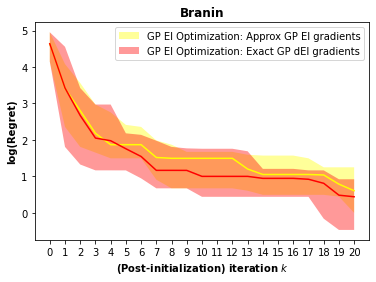

In [ ]:
### Visualise!

title = func
plt.figure()

plt.plot(median_approx, color = 'Yellow')
plt.plot(median_exact, color = 'Red')

xstar = np.arange(0, iters+1, step=1)
plt.fill_between(xstar, lower_approx, upper_approx, facecolor = 'Yellow', alpha=0.4, label='GP EI Optimization: Approx GP EI gradients')
plt.fill_between(xstar, lower_exact, upper_exact, facecolor = 'Red', alpha=0.4, label='GP EI Optimization: Exact GP dEI gradients')

plt.title(title, weight = 'bold')
plt.xlabel('(Post-initialization) iteration $\it{k}$', weight = 'bold')
plt.ylabel('log(Regret)', weight = 'bold') 
plt.legend(loc=1) # add plot legend

### Make the x-ticks integers, not floats:
count = len(xstar)
plt.xticks(np.arange(count), np.arange(0, count))
plt.show() #visualize!

In [ ]:
time_approx, time_exact


(179.12042999267578, 379.12905049324036)

In [ ]:
exact21_results, exact21_results[19:20].index[0]


(           0
 0   1.412616
 7   1.184945
 2   1.164129
 17  0.986176
 8   0.920960
 15  0.890363
 14  0.809876
 6   0.803586
 9   0.484137
 19  0.440859
 13  0.439609
 16  0.373659
 10 -0.160476
 5  -0.427548
 1  -0.468361
 3  -0.621879
 11 -0.787840
 18 -0.862815
 12 -1.898026
 4  -3.727682, 4)

In [ ]:
str_exact = str(exact21_results[19:20].index[0]+1)
str_exact


'5'

In [ ]:
eval_exactMinIQR_vsCorrApproxExperiment = eval('approx_' + str_exact)
eval_exactMinIQR_vsCorrApproxExperiment_minAcqFunc = eval_exactMinIQR_vsCorrApproxExperiment.history[eval_exactMinIQR_vsCorrApproxExperiment.history.index(eval_exactMinIQR_vsCorrApproxExperiment.tau)-1]
eval_exactMinIQR_vsCorrApproxExperiment_simpleRegret = np.log(-eval_exactMinIQR_vsCorrApproxExperiment.tau + y_global_orig)

eval_exactMinIQR_vsCorrApproxExperiment.tau, eval_exactMinIQR_vsCorrApproxExperiment_minAcqFunc, eval_exactMinIQR_vsCorrApproxExperiment_simpleRegret


(-2.7427315707408138, -3.3729852694192193, 0.8522191185675699)

In [ ]:
### Final iteration: best "approx" experiment results (as above)

np.random.seed(int(str_exact))
eval_exactMinIQR_vsCorrApproxExperiment.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max AcqFunc.
init	 [-1.67010243 13.06098459]	 -25.390690545664548	 -25.311309190989615	    
init	 [-1.89921267 13.77916362]	 -25.311309190989615	 -25.311309190989615	    
init	 [2.32616783 9.17615794]	 -41.60147975414021	 -25.311309190989615	    
init	 [6.48861785 7.77626982]	 -63.81281921768236	 -25.311309190989615	    
init	 [-0.54799248  2.81581843]	 -34.966203644931994	 -25.311309190989615	    
1	 [8.84124421 0.03321319]	 -5.96108856337545	 -5.96108856337545	 -25.311309190989423
2  	 [ 8.39476442 14.47736321]	 -167.21523769473345	 -5.96108856337545	 -5.961907109366957
3  	 [-4.1375067   7.24495487]	 -61.80559119709111	 -5.96108856337545	 -5.961905558672704
4  	 [-5.  0.]	 -308.12909601160663	 -5.96108856337545	 -5.961890653984154
5  	 [3.90218642 0.        ]	 -6.129536698755416	 -5.96108856337545	 -5.961875513211085
6  	 [ 3.02991629 15.        ]	 -160.13370433331355	 -5.96108856337545	 -5.961819911480742
7	 [10. 

In [ ]:
eval_exactMinIQR_vsCorrApproxExperiment.x_best, np.round(eval_exactMinIQR_vsCorrApproxExperiment.f_best, 2), eval_exactMinIQR_vsCorrApproxExperiment.best, eval_exactMinIQR_vsCorrApproxExperiment.x_best[np.argmin(eval_exactMinIQR_vsCorrApproxExperiment.f_best)] #### i.e. minAcqFunc returned


(array([[ 6.31678856,  0.        ],
        [ 1.06971445, 12.00605283],
        [ 7.34383333, 12.50382019],
        [-3.82954191,  7.18026343],
        [ 2.8464973 ,  6.14467566],
        [-4.82815024, 11.54458915],
        [ 6.13447095,  7.41269715],
        [-2.76347052,  2.57305414],
        [-4.84717018,  8.2528617 ],
        [ 5.5393689 , 10.06599412],
        [ 2.8464956 ,  6.14467619],
        [ 5.56579315,  8.26223595],
        [ 3.04869934,  2.17647827],
        [10.        ,  1.25176498],
        [ 4.88338796, 10.69188884],
        [ 1.06971917, 12.00605379],
        [ 9.4061208 , 11.03023185],
        [ 5.48499392,  5.04843535],
        [ 3.04866175,  2.17649383],
        [ 4.6024224 , 12.73171112]]),
 array([-2.47, -2.38, -0.  , -0.  , -2.32, -0.  , -0.  , -0.  , -0.  ,
        -0.  , -2.32, -0.  , -2.04, -1.47, -0.  , -2.38, -0.  , -1.66,
        -2.04, -0.  ]),
 array([6.31678856, 0.        ]),
 array([6.31678856, 0.        ]))

In [ ]:
eval_exactMinIQR = eval('exact_' + str_exact)
eval_exactMinIQR_minAcqFunc = eval_exactMinIQR.history[eval_exactMinIQR.history.index(eval_exactMinIQR.tau)-1]
eval_exactMinIQR_simpleRegret  = np.log(-eval_exactMinIQR.tau + y_global_orig)

eval_exactMinIQR.tau, eval_exactMinIQR_minAcqFunc, eval_exactMinIQR_simpleRegret


(-0.421935515032267, -3.3891902996317853, -3.7276820293567514)

In [ ]:
### Final iteration: best "exact" experiment results (as above)

np.random.seed(int(str_exact))
eval_exactMinIQR.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max AcqFunc.
init	 [-1.67010243 13.06098459]	 -25.390690545664548	 -25.311309190989615	    
init	 [-1.89921267 13.77916362]	 -25.311309190989615	 -25.311309190989615	    
init	 [2.32616783 9.17615794]	 -41.60147975414021	 -25.311309190989615	    
init	 [6.48861785 7.77626982]	 -63.81281921768236	 -25.311309190989615	    
init	 [-0.54799248  2.81581843]	 -34.966203644931994	 -25.311309190989615	    
1	 [8.84124421 0.03321319]	 -5.96108856337545	 -5.96108856337545	 -25.311309180989422
2  	 [ 8.39476442 14.47736321]	 -167.21523769473345	 -5.96108856337545	 -5.961907098265746
3  	 [-5.          8.10986515]	 -95.12466680670255	 -5.96108856337545	 -5.96190691908924
4  	 [-5.  0.]	 -308.12909601160663	 -5.96108856337545	 -5.961890642966492
5  	 [4.68041959 2.64376529]	 -11.288061329654056	 -5.96108856337545	 -5.961858176609415
6  	 [ 3.07485242 14.94793353]	 -159.6914920096218	 -5.96108856337545	 -5.961813011235977
7	 [10.  

In [ ]:
eval_exactMinIQR.x_best, np.round(eval_exactMinIQR.f_best, 2), eval_exactMinIQR.best, eval_exactMinIQR.x_best[np.argmin(eval_exactMinIQR.f_best)] #### i.e. minAcqFunc returned


(array([[ 9.24379926,  2.36760576],
        [ 1.01376922, 12.21447849],
        [ 7.34383333, 12.50382019],
        [-3.82954191,  7.18026343],
        [ 2.75984482,  6.91603091],
        [-4.82815024, 11.54458915],
        [ 6.13447095,  7.41269715],
        [-2.74252399,  2.59400067],
        [-4.84717018,  8.2528617 ],
        [ 5.5393689 , 10.06599412],
        [ 3.54280488,  6.93385131],
        [ 5.56579315,  8.26223595],
        [ 3.64898845,  1.2475165 ],
        [10.        ,  2.09532251],
        [ 4.88338796, 10.69188884],
        [ 2.20289927, 11.82402336],
        [ 9.4061208 , 11.03023185],
        [ 4.29287895,  0.61803757],
        [ 2.88138393,  2.0166646 ],
        [ 3.51535191, 11.64464062]]),
 array([-0.7 , -0.68, -0.  , -0.  , -0.1 , -0.  , -0.  , -0.01, -0.  ,
        -0.  , -0.29, -0.  , -0.19, -0.78, -0.  , -0.52, -0.  , -0.47,
        -0.32, -0.49]),
 array([10.        ,  2.09532251]),
 array([10.        ,  2.09532251]))

In [ ]:
eval_exactMinIQR.tau > eval_exactMinIQR_vsCorrApproxExperiment.tau # Exact gradients' model: y-value is greater

True

In [ ]:
eval_exactMinIQR_minAcqFunc > eval_exactMinIQR_vsCorrApproxExperiment_minAcqFunc # Exact gradients' model: best AcqFunc is greater


False

In [ ]:
eval_exactMinIQR_simpleRegret < eval_exactMinIQR_vsCorrApproxExperiment_simpleRegret # Exact gradients' model: simple regret's natural log is lower


True

In [ ]:
eval_exactMinIQR_minAcqFunc, eval_exactMinIQR_vsCorrApproxExperiment_minAcqFunc, eval_exactMinIQR_minAcqFunc/eval_exactMinIQR_vsCorrApproxExperiment_minAcqFunc


(-3.3891902996317853, -3.3729852694192193, 1.0048043584297528)

In [ ]:
### MinAcqFunc Comparison: Approximate Gradients

approx_1minAcqFunc = approx_1.history[:-1][1::2]
approx_2minAcqFunc = approx_2.history[:-1][1::2]
approx_3minAcqFunc = approx_3.history[:-1][1::2]
approx_4minAcqFunc = approx_4.history[:-1][1::2]
approx_5minAcqFunc = approx_5.history[:-1][1::2]
approx_6minAcqFunc = approx_6.history[:-1][1::2]
approx_7minAcqFunc = approx_7.history[:-1][1::2]
approx_8minAcqFunc = approx_8.history[:-1][1::2]
approx_9minAcqFunc = approx_9.history[:-1][1::2]
approx_10minAcqFunc = approx_10.history[:-1][1::2]
approx_11minAcqFunc = approx_11.history[:-1][1::2]
approx_12minAcqFunc = approx_12.history[:-1][1::2]
approx_13minAcqFunc = approx_13.history[:-1][1::2]
approx_14minAcqFunc = approx_14.history[:-1][1::2]
approx_15minAcqFunc = approx_15.history[:-1][1::2]
approx_16minAcqFunc = approx_16.history[:-1][1::2]
approx_17minAcqFunc = approx_17.history[:-1][1::2]
approx_18minAcqFunc = approx_18.history[:-1][1::2]
approx_19minAcqFunc = approx_19.history[:-1][1::2]
approx_20minAcqFunc = approx_20.history[:-1][1::2]


In [ ]:
### MinAcqFunc Comparison: Exact Gradients

exact_1minAcqFunc = exact_1.history[:-1][1::2]
exact_2minAcqFunc = exact_2.history[:-1][1::2]
exact_3minAcqFunc = exact_3.history[:-1][1::2]
exact_4minAcqFunc = exact_4.history[:-1][1::2]
exact_5minAcqFunc = exact_5.history[:-1][1::2]
exact_6minAcqFunc = exact_6.history[:-1][1::2]
exact_7minAcqFunc = exact_7.history[:-1][1::2]
exact_8minAcqFunc = exact_8.history[:-1][1::2]
exact_9minAcqFunc = exact_9.history[:-1][1::2]
exact_10minAcqFunc = exact_10.history[:-1][1::2]
exact_11minAcqFunc = exact_11.history[:-1][1::2]
exact_12minAcqFunc = exact_12.history[:-1][1::2]
exact_13minAcqFunc = exact_13.history[:-1][1::2]
exact_14minAcqFunc = exact_14.history[:-1][1::2]
exact_15minAcqFunc = exact_15.history[:-1][1::2]
exact_16minAcqFunc = exact_16.history[:-1][1::2]
exact_17minAcqFunc = exact_17.history[:-1][1::2]
exact_18minAcqFunc = exact_18.history[:-1][1::2]
exact_19minAcqFunc = exact_19.history[:-1][1::2]
exact_20minAcqFunc = exact_20.history[:-1][1::2]


In [ ]:
### MinAcqFunc Comparison: Experiment 1

minAcqFuncApprox1 = np.mean(approx_1minAcqFunc)
minAcqFuncExact1 = np.mean(exact_1minAcqFunc)
ratio1 = minAcqFuncApprox1/minAcqFuncExact1
approx_1.tau, exact_1.tau, minAcqFuncApprox1, minAcqFuncExact1, ratio1


(-4.859191184895716,
 -4.504572815126114,
 -5.895797465643497,
 -5.720169825150522,
 1.0307032213835283)

In [ ]:
### MinAcqFunc Comparison: Experiment 2

minAcqFuncApprox2 = np.mean(approx_2minAcqFunc)
minAcqFuncExact2 = np.mean(exact_2minAcqFunc)
ratio2 = minAcqFuncApprox2/minAcqFuncExact2
approx_2.tau, exact_2.tau, minAcqFuncApprox2, minAcqFuncExact2, ratio2


(-1.3984593420568778,
 -1.0239145109053958,
 -2.0931965790395273,
 -2.057809908371798,
 1.017196277714363)

In [ ]:
### MinAcqFunc Comparison: Experiment 3

minAcqFuncApprox3 = np.mean(approx_3minAcqFunc)
minAcqFuncExact3 = np.mean(exact_3minAcqFunc)
ratio3 = minAcqFuncApprox3/minAcqFuncExact3
approx_3.tau, exact_3.tau, minAcqFuncApprox3, minAcqFuncExact3, ratio3


(-3.2226782045042226,
 -3.6010193697779265,
 -7.110777856956406,
 -4.887906043495027,
 1.4547697508260502)

In [ ]:
### MinAcqFunc Comparison: Experiment 4

minAcqFuncApprox4 = np.mean(approx_4minAcqFunc)
minAcqFuncExact4 = np.mean(exact_4minAcqFunc)
ratio4 = minAcqFuncApprox4/minAcqFuncExact4
approx_4.tau, exact_4.tau, minAcqFuncApprox4, minAcqFuncExact4, ratio4


(-0.5969307952604961,
 -0.9348218204625756,
 -4.3073945280969195,
 -6.052148080027507,
 0.7117133406420787)

In [ ]:
### MinAcqFunc Comparison: Experiment 5

minAcqFuncApprox5 = np.mean(approx_5minAcqFunc)
minAcqFuncExact5 = np.mean(exact_5minAcqFunc)
ratio5 = minAcqFuncApprox5/minAcqFuncExact5
approx_5.tau, exact_5.tau, minAcqFuncApprox5, minAcqFuncExact5, ratio5


(-2.7427315707408138,
 -0.421935515032267,
 -5.395015972428813,
 -5.282915015860297,
 1.0212195267635327)

In [ ]:
### MinAcqFunc Comparison: Experiment 6

minAcqFuncApprox6 = np.mean(approx_6minAcqFunc)
minAcqFuncExact6 = np.mean(exact_6minAcqFunc)
ratio6 = minAcqFuncApprox6/minAcqFuncExact6
approx_6.tau, exact_6.tau, minAcqFuncApprox6, minAcqFuncExact6, ratio6


(-0.5466720813438801,
 -1.0499933199010147,
 -5.674956803663834,
 -7.381215899762982,
 0.7688376658710202)

In [ ]:
### MinAcqFunc Comparison: Experiment 7

minAcqFuncApprox7 = np.mean(approx_7minAcqFunc)
minAcqFuncExact7 = np.mean(exact_7minAcqFunc)
ratio7 = minAcqFuncApprox7/minAcqFuncExact7
approx_7.tau, exact_7.tau, minAcqFuncApprox7, minAcqFuncExact7, ratio7


(-2.5942573673950236,
 -2.6314226354824584,
 -3.4892902758442057,
 -3.5020302035962656,
 0.9963621308180103)

In [ ]:
### MinAcqFunc Comparison: Experiment 8

minAcqFuncApprox8 = np.mean(approx_8minAcqFunc)
minAcqFuncExact8 = np.mean(exact_8minAcqFunc)
ratio8 = minAcqFuncApprox8/minAcqFuncExact8
approx_8.tau, exact_8.tau, minAcqFuncApprox8, minAcqFuncExact8, ratio8


(-6.430480819418818,
 -3.6683923541112007,
 -6.833120469297105,
 -5.933485904095639,
 1.151619904343328)

In [ ]:
### MinAcqFunc Comparison: Experiment 9

minAcqFuncApprox9 = np.mean(approx_9minAcqFunc)
minAcqFuncExact9 = np.mean(exact_9minAcqFunc)
ratio9 = minAcqFuncApprox9/minAcqFuncExact9
approx_9.tau, exact_9.tau, minAcqFuncApprox9, minAcqFuncExact9, ratio9


(-2.2001667247670733,
 -2.909586327372441,
 -3.30748625304902,
 -3.1688750275656803,
 1.0437414616472964)

In [ ]:
### MinAcqFunc Comparison: Experiment 10

minAcqFuncApprox10 = np.mean(approx_10minAcqFunc)
minAcqFuncExact10 = np.mean(exact_10minAcqFunc)
ratio10 = minAcqFuncApprox10/minAcqFuncExact10
approx_10.tau, exact_10.tau, minAcqFuncApprox10, minAcqFuncExact10, ratio10


(-2.231488818914995,
 -2.020660742058113,
 -2.4572620598214754,
 -2.510132277689517,
 0.9789372781912884)

In [ ]:
### MinAcqFunc Comparison: Experiment 11

minAcqFuncApprox11 = np.mean(approx_11minAcqFunc)
minAcqFuncExact11 = np.mean(exact_11minAcqFunc)
ratio11 = minAcqFuncApprox11/minAcqFuncExact11
approx_11.tau, exact_11.tau, minAcqFuncApprox11, minAcqFuncExact11, ratio11


(-0.9919713297704416,
 -1.2496251948904433,
 -5.0551475435394355,
 -4.771026115688492,
 1.0595514300197753)

In [ ]:
### MinAcqFunc Comparison: Experiment 12

minAcqFuncApprox12 = np.mean(approx_12minAcqFunc)
minAcqFuncExact12 = np.mean(exact_12minAcqFunc)
ratio12 = minAcqFuncApprox12/minAcqFuncExact12
approx_12.tau, exact_12.tau, minAcqFuncApprox12, minAcqFuncExact12, ratio12


(-0.5499315281120278,
 -0.5499315281120278,
 -1.0607667579826578,
 -1.0527591735958206,
 1.0076062831725194)

In [ ]:
### MinAcqFunc Comparison: Experiment 13

minAcqFuncApprox13 = np.mean(approx_13minAcqFunc)
minAcqFuncExact13 = np.mean(exact_13minAcqFunc)
ratio13 = minAcqFuncApprox13/minAcqFuncExact13
approx_13.tau, exact_13.tau, minAcqFuncApprox13, minAcqFuncExact13, ratio13


(-2.035760641591324,
 -0.5477511752924471,
 -9.594323717534618,
 -2.885548999053448,
 3.324956090047981)

In [ ]:
### MinAcqFunc Comparison: Experiment 14

minAcqFuncApprox14 = np.mean(approx_14minAcqFunc)
minAcqFuncExact14 = np.mean(exact_14minAcqFunc)
ratio14 = minAcqFuncApprox14/minAcqFuncExact14
approx_14.tau, exact_14.tau, minAcqFuncApprox14, minAcqFuncExact14, ratio14


(-1.4149920024014744,
 -1.4149920024014744,
 -1.6205917614833787,
 -1.5973565668989154,
 1.0145460287740087)

In [ ]:
### MinAcqFunc Comparison: Experiment 15

minAcqFuncApprox15 = np.mean(approx_15minAcqFunc)
minAcqFuncExact15 = np.mean(exact_15minAcqFunc)
ratio15 = minAcqFuncApprox15/minAcqFuncExact15
approx_15.tau, exact_15.tau, minAcqFuncApprox15, minAcqFuncExact15, ratio15


(-3.459585399897726,
 -2.6455160649188842,
 -6.9192472087304875,
 -6.288940411064,
 1.1002246414288808)

In [ ]:
### MinAcqFunc Comparison: Experiment 16

minAcqFuncApprox16 = np.mean(approx_16minAcqFunc)
minAcqFuncExact16 = np.mean(exact_16minAcqFunc)
ratio16 = minAcqFuncApprox16/minAcqFuncExact16
approx_16.tau, exact_16.tau, minAcqFuncApprox16, minAcqFuncExact16, ratio16


(-2.715864006988424,
 -2.715864006988424,
 -2.6792571460503973,
 -2.6516334389620733,
 1.0104176190729957)

In [ ]:
### MinAcqFunc Comparison: Experiment 17

minAcqFuncApprox17 = np.mean(approx_17minAcqFunc)
minAcqFuncExact17 = np.mean(exact_17minAcqFunc)
ratio17 = minAcqFuncApprox17/minAcqFuncExact17
approx_17.tau, exact_17.tau, minAcqFuncApprox17, minAcqFuncExact17, ratio17


(-2.0179821894263945,
 -1.8509281105180406,
 -4.030269627242974,
 -3.2763278349039444,
 1.2301179339585635)

In [ ]:
### MinAcqFunc Comparison: Experiment 18

minAcqFuncApprox18 = np.mean(approx_18minAcqFunc)
minAcqFuncExact18 = np.mean(exact_18minAcqFunc)
ratio18 = minAcqFuncApprox18/minAcqFuncExact18
approx_18.tau, exact_18.tau, minAcqFuncApprox18, minAcqFuncExact18, ratio18


(-5.719079686897693,
 -3.078850151318427,
 -6.5878496378884295,
 -6.48289164529356,
 1.0161899964302297)

In [ ]:
### MinAcqFunc Comparison: Experiment 19

minAcqFuncApprox19 = np.mean(approx_19minAcqFunc)
minAcqFuncExact19 = np.mean(exact_19minAcqFunc)
ratio19 = minAcqFuncApprox19/minAcqFuncExact19
approx_19.tau, exact_19.tau, minAcqFuncApprox19, minAcqFuncExact19, ratio19


(-0.4133326694001145,
 -0.8198597583535783,
 -1.3162390660602163,
 -1.3374830014874521,
 0.9841164819264171)

In [ ]:
### MinAcqFunc Comparison: Experiment 20

minAcqFuncApprox20 = np.mean(approx_20minAcqFunc)
minAcqFuncExact20 = np.mean(exact_20minAcqFunc)
ratio20 = minAcqFuncApprox20/minAcqFuncExact20
approx_20.tau, exact_20.tau, minAcqFuncApprox20, minAcqFuncExact20, ratio20


(-5.207839407943306,
 -1.9519292536607047,
 -7.0424494717458215,
 -4.927294194635118,
 1.4292731859635466)

In [ ]:
num = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]
ApproxTau = [approx_1.tau,approx_2.tau,approx_3.tau,approx_4.tau,approx_5.tau,approx_6.tau,approx_7.tau,approx_8.tau,approx_9.tau,approx_10.tau,approx_11.tau,approx_12.tau,approx_13.tau,approx_14.tau,approx_15.tau,approx_16.tau,approx_17.tau,approx_18.tau,approx_19.tau,approx_20.tau]
ExactTau = [exact_1.tau,exact_2.tau,exact_3.tau,exact_4.tau,exact_5.tau,exact_6.tau,exact_7.tau,exact_8.tau,exact_9.tau,exact_10.tau,exact_11.tau,exact_12.tau,exact_13.tau,exact_14.tau,exact_15.tau,exact_16.tau,exact_17.tau,exact_18.tau,exact_19.tau,exact_20.tau]
AvgMinAcqFuncExact = [minAcqFuncExact1,minAcqFuncExact2,minAcqFuncExact3,minAcqFuncExact4,minAcqFuncExact5,minAcqFuncExact6,minAcqFuncExact7,minAcqFuncExact8,minAcqFuncExact9,minAcqFuncExact10,minAcqFuncExact11,minAcqFuncExact12,minAcqFuncExact13,minAcqFuncExact14,minAcqFuncExact15,minAcqFuncExact16,minAcqFuncExact17,minAcqFuncExact18,minAcqFuncExact19,minAcqFuncExact20]
AvgMinAcqFuncApprox = [minAcqFuncApprox1,minAcqFuncApprox2,minAcqFuncApprox3,minAcqFuncApprox4,minAcqFuncApprox5,minAcqFuncApprox6,minAcqFuncApprox7,minAcqFuncApprox8,minAcqFuncApprox9,minAcqFuncApprox10,minAcqFuncApprox11,minAcqFuncApprox12,minAcqFuncApprox13,minAcqFuncApprox14,minAcqFuncApprox15,minAcqFuncApprox16,minAcqFuncApprox17,minAcqFuncApprox18,minAcqFuncApprox19,minAcqFuncApprox20]
ratio = [ratio1,ratio2,ratio3,ratio4,ratio5,ratio6,ratio7,ratio8,ratio9,ratio10,ratio11,ratio12,ratio13,ratio14,ratio15,ratio16,ratio17,ratio18,ratio19,ratio20]


In [ ]:
def greaterThan(a, b):
  lis =[]
  #convert to list
  a = list(a)
  b = list(b)
  c = "Yes"
  d = "No"
  e = "equal"
  for first, first_te in zip(a, b):
      if first < first_te:
          lis.append(d)
      elif first > first_te:
          lis.append(c)
      else:
          lis.append(e)
  return lis

greaterAcqFunc = greaterThan(AvgMinAcqFuncExact, AvgMinAcqFuncApprox)


In [ ]:
def greaterRatio(a):
  lis =[]
  #convert to list
  a = list(a)
  b = "Yes"
  c = "No"
  d = "equal"
  for first, in zip(a):
      if first < 1:
          lis.append(c)
      elif first > 1:
          lis.append(b)
      else:
          lis.append(d)
  return lis

greaterRatio = greaterRatio(ratio)


In [ ]:
df = pd.DataFrame(dict(Experiment=num,
                  ExactTau=ExactTau,
                  ApproxTau=ApproxTau,
                  AvgMinAcqFuncExact=AvgMinAcqFuncExact,
                  GreaterAcqFunc = greaterAcqFunc,
                  AvgMinAcqFuncApprox=AvgMinAcqFuncApprox,
                  Ratio = ratio,
                  GreaterRatio = greaterRatio))
df.sort_values(by=['ExactTau'], inplace=True, ascending=False)
print(df.to_latex(index=False))


\begin{tabular}{rrrrlrrl}
\toprule
 Experiment &  ExactTau &  ApproxTau &  AvgMinAcqFuncExact & GreaterAcqFunc &  AvgMinAcqFuncApprox &    Ratio & GreaterRatio \\
\midrule
          5 & -0.421936 &  -2.742732 &           -5.282915 &            Yes &            -5.395016 & 1.021220 &          Yes \\
         13 & -0.547751 &  -2.035761 &           -2.885549 &            Yes &            -9.594324 & 3.324956 &          Yes \\
         12 & -0.549932 &  -0.549932 &           -1.052759 &            Yes &            -1.060767 & 1.007606 &          Yes \\
         19 & -0.819860 &  -0.413333 &           -1.337483 &             No &            -1.316239 & 0.984116 &           No \\
          4 & -0.934822 &  -0.596931 &           -6.052148 &             No &            -4.307395 & 0.711713 &           No \\
          2 & -1.023915 &  -1.398459 &           -2.057810 &            Yes &            -2.093197 & 1.017196 &          Yes \\
          6 & -1.049993 &  -0.546672 &           -7.381216 &

In [ ]:
avg_list = ['ExactTau', 'ApproxTau', 'AvgMinAcqFuncExact','AvgMinAcqFuncApprox']
avg = df[avg_list].mean()
avg.name = 'Average'
df = df.append(avg.transpose())
df.fillna(value='', inplace=True)
df


,Experiment,ExactTau,ApproxTau,AvgMinAcqFuncExact,GreaterAcqFunc,AvgMinAcqFuncApprox,Ratio,GreaterRatio
4,5.0,-0.421936,-2.742732,-5.282915,Yes,-5.395016,1.02122,Yes
12,13.0,-0.547751,-2.035761,-2.885549,Yes,-9.594324,3.324956,Yes
11,12.0,-0.549932,-0.549932,-1.052759,Yes,-1.060767,1.007606,Yes
18,19.0,-0.819860,-0.413333,-1.337483,No,-1.316239,0.984116,No
3,4.0,-0.934822,-0.596931,-6.052148,No,-4.307395,0.711713,No
1,2.0,-1.023915,-1.398459,-2.057810,Yes,-2.093197,1.017196,Yes
5,6.0,-1.049993,-0.546672,-7.381216,No,-5.674957,0.768838,No
10,11.0,-1.249625,-0.991971,-4.771026,Yes,-5.055148,1.059551,Yes
13,14.0,-1.414992,-1.414992,-1.597357,Yes,-1.620592,1.014546,Yes
16,17.0,-1.850928,-2.017982,-3.276328,Yes,-4.030270,1.230118,Yes


In [140]:
print('Ratio of Average ExactTau to Average ApproxTau:', np.round(avg[1]/avg[0], 5))
print('Ratio of Average AvgMinAcqFuncExact to Average AvgMinAcqFuncApprox:', np.round(avg[3]/avg[2], 5))
print('Number of experiments where AvgMinAcqFuncExact exceeds AvgMinAcqFuncApprox:', df['GreaterAcqFunc'].value_counts()['Yes'])
print('Number of experiments where Ratio exceeds 1.0:', df['GreaterRatio'].value_counts()['Yes'])


Ratio of Average ExactTau to Average ApproxTau: 1.29698
Ratio of Average AvgMinAcqFuncExact to Average AvgMinAcqFuncApprox: 1.13089
Number of experiments where AvgMinAcqFuncExact exceeds AvgMinAcqFuncApprox: 15
Number of experiments where Ratio exceeds 1.0: 15
